In [ ]:
import pickle
import polars as pl

# 路徑
transform_path = "data/extra_features/transform_dict_companyID.pkl"

# 讀取
with open(transform_path, "rb") as f:
    transform_dict = pickle.load(f)

# 還原成 DataFrame
all_stats = pl.DataFrame(transform_dict["all_stats"])
cabin_mode = pl.DataFrame(transform_dict["cabin_mode"])
transfer_mode = pl.DataFrame(transform_dict["transfer_mode"])
transfer_num_mode = pl.DataFrame(transform_dict["transfer_num_mode"])
total_counts = pl.DataFrame(transform_dict["total_counts"])

# 如果你要把 global_mean 也看進來，可以再 concat
global_mean = pl.DataFrame(transform_dict["global_mean"])

# 把 global_mean 加到 all_stats 最後一行（這是 fallback）
all_stats = pl.concat([all_stats, global_mean])

# 如果要看最終的每家公司完整資訊
company_summary = (
    all_stats
    .join(cabin_mode, on="companyID", how="left")
    .join(transfer_mode, on="companyID", how="left")
    .join(transfer_num_mode, on="companyID", how="left")
    .join(total_counts, on="companyID", how="left")
)
# === Null 轉 0 ===
company_summary_filled = company_summary.fill_null(0)





In [7]:
company_summary_filled

companyID,totalPrice_mean,taxes_mean,legs0_duration_mean,legs1_duration_mean,cabin_class_mean,total_num_transfers_mean,legs0_departureAt_hour_mean,legs0_arrivalAt_hour_mean,legs1_departureAt_hour_mean,legs1_arrivalAt_hour_mean,selected_count,mode_cabin_class,mode_has_transfer,mode_transfer_num,total_occurrences
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64
27296,94766.0,766.0,180.0,185.0,2.0,0.0,23.0,4.0,13.0,14.0,1,2,0,0,12
25337,25657.5,1432.5,127.5,0.0,1.0,0.0,16.0,18.0,-1.0,-1.0,2,1,0,0,206
53359,23911.611227,1847.713098,250.977131,218.151261,1.0,0.164241,12.785863,12.804574,2.594595,2.964657,481,1,0,0,19775
51287,22108.662162,1138.981982,189.459459,203.409091,1.027027,0.166667,13.418919,13.585586,11.81982,11.184685,222,1,0,0,40891
62666,10749.0,994.0,100.0,110.0,1.0,0.0,16.0,18.0,19.0,20.0,1,1,0,0,549
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
42188,20013.034836,1010.807377,169.282787,176.894273,1.079918,0.036885,13.442623,14.97541,6.790984,6.393443,488,1,0,0,115309
59596,16689.666667,1458.333333,345.0,285.0,1.0,1.333333,11.666667,18.0,4.666667,5.333333,3,1,1,1,108
25691,75160.0,15542.5,572.5,0.0,1.0,1.0,6.0,16.0,-1.0,-1.0,2,1,1,1,223


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_7854/1840823383.py:7: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  if c not in exclude_cols and dtype in pl.NUMERIC_DTYPES]


✅ 數值欄: ['totalPrice_mean', 'taxes_mean', 'legs0_duration_mean', 'legs1_duration_mean', 'cabin_class_mean', 'total_num_transfers_mean', 'legs0_departureAt_hour_mean', 'legs0_arrivalAt_hour_mean', 'legs1_departureAt_hour_mean', 'legs1_arrivalAt_hour_mean', 'selected_count', 'mode_cabin_class', 'mode_has_transfer', 'mode_transfer_num', 'total_occurrences']


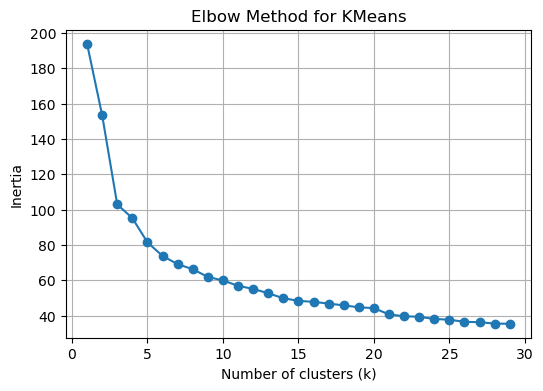

shape: (10, 17)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ companyID ┆ totalPric ┆ taxes_mea ┆ legs0_dur ┆ … ┆ mode_has_ ┆ mode_tran ┆ total_occ ┆ cluster_ │
│ ---       ┆ e_mean    ┆ n         ┆ ation_mea ┆   ┆ transfer  ┆ sfer_num  ┆ urrences  ┆ label    │
│ i64       ┆ ---       ┆ ---       ┆ n         ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ f64       ┆ f64       ┆ ---       ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i32      │
│           ┆           ┆           ┆ f64       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 27296     ┆ 94766.0   ┆ 766.0     ┆ 180.0     ┆ … ┆ 0         ┆ 0         ┆ 12        ┆ 1        │
│ 25337     ┆ 25657.5   ┆ 1432.5    ┆ 127.5     ┆ … ┆ 0         ┆ 0         ┆ 206       ┆ 0        │
│ 53359     ┆ 23911.611 ┆ 1847.7130 ┆ 250.97713 ┆ … ┆ 0         ┆ 0        

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# === 只對數值欄做 normalization ===
exclude_cols = ["companyID"]
numeric_cols = [c for c, dtype in company_summary_filled.schema.items()
                if c not in exclude_cols and dtype in pl.NUMERIC_DTYPES]

print(f"✅ 數值欄: {numeric_cols}")

# 轉 numpy
X_np = company_summary_filled.select(numeric_cols).to_numpy()

# MinMax normalization
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_np)

# === 先用一個 k 分群 (例如 k=5) ===
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X_scaled)

# 把 label 加回 DataFrame
company_summary_clustered = company_summary_filled.with_columns(
    pl.Series("cluster_label", labels)
)

# 顯示結果
print(company_summary_clustered.head(10))


In [23]:
import pickle
import os

# 檔案路徑
output_dir = "data/extra_features"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "transform_dict_cluster.pkl")

# 建 transform_dict
transform_dict = {
    "cluster_summary": final_df.to_dict(as_series=False)
}

# 儲存
with open(output_path, "wb") as f:
    pickle.dump(transform_dict, f)

print(f"✅ 已儲存 transform_dict: {output_path}")


✅ 已儲存 transform_dict: data/extra_features/transform_dict_cluster.pkl


In [ ]:
# 先自動取得要聚合的欄位
exclude_cols = {"companyID", "cluster_label"}
base_features = [c for c in company_summary_clustered.columns if c not in exclude_cols]

# 聚合: 每個 cluster 的 mean
agg_exprs = []
for feat in base_features:
    agg_exprs.append(
        pl.col(feat).mean().alias(f"{feat}_mean")
    )

cluster_summary = (
    company_summary_clustered
    .group_by("cluster_label")
    .agg(agg_exprs)
    .sort("cluster_label")
)

# 把 cluster_summary merge 回原始資料
company_with_cluster_features = (
    company_summary_clustered
    .join(
        cluster_summary,
        on="cluster_label",
        how="left"
    )
)

# 最後整理成你要的樣子
final_df = company_with_cluster_features.select(
    ["companyID", "cluster_label"] + cluster_summary.drop("cluster_label").columns
)

print(final_df)


shape: (642, 17)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ companyID ┆ cluster_l ┆ totalPric ┆ taxes_mea ┆ … ┆ mode_cabi ┆ mode_has_ ┆ mode_tran ┆ total_oc │
│ ---       ┆ abel      ┆ e_mean_me ┆ n_mean    ┆   ┆ n_class_m ┆ transfer_ ┆ sfer_num_ ┆ currence │
│ i64       ┆ ---       ┆ an        ┆ ---       ┆   ┆ ean       ┆ mean      ┆ mean      ┆ s_mean   │
│           ┆ i32       ┆ ---       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 27296     ┆ 1         ┆ 31118.606 ┆ 3458.9307 ┆ … ┆ 1.011905  ┆ 0.0       ┆ 0.0       ┆ 35478.59 │
│           ┆           ┆ 811       ┆ 04        ┆   ┆           ┆           ┆           ┆ 127      │
│ 25337     ┆ 0         ┆ 31749.003 ┆ 2682.0508 ┆ … ┆ 1.036313  ┆ 0.0     

In [30]:
import os
import pickle
import polars as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

def build_cluster_transform_dict(
    transform_path: str,
    output_path: str,
    k: int = 3
):
    """
    從 transform_dict_companyID.pkl 讀取，進行 KMeans clustering，生成 cluster summary，並存成 transform_dict_cluster.pkl
    """
    # === 讀取 transform_dict ===
    with open(transform_path, "rb") as f:
        transform_dict = pickle.load(f)

    all_stats = pl.DataFrame(transform_dict["all_stats"])
    cabin_mode = pl.DataFrame(transform_dict["cabin_mode"])
    transfer_mode = pl.DataFrame(transform_dict["transfer_mode"])
    transfer_num_mode = pl.DataFrame(transform_dict["transfer_num_mode"])
    total_counts = pl.DataFrame(transform_dict["total_counts"])
    global_mean = pl.DataFrame(transform_dict["global_mean"])

    # 加上 fallback row
    all_stats = pl.concat([all_stats, global_mean])

    # 合併成 summary
    company_summary = (
        all_stats
        .join(cabin_mode, on="companyID", how="left")
        .join(transfer_mode, on="companyID", how="left")
        .join(transfer_num_mode, on="companyID", how="left")
        .join(total_counts, on="companyID", how="left")
    )

    # Null -> 0
    company_summary_filled = company_summary.fill_null(0)

    # Numeric columns
    exclude_cols = {"companyID"}
    numeric_cols = [
        c for c, dtype in company_summary_filled.schema.items()
        if c not in exclude_cols and dtype in pl.NUMERIC_DTYPES
    ]

    # Scaling
    X_np = company_summary_filled.select(numeric_cols).to_numpy()
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_np)

    # Clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_scaled)

    company_summary_clustered = company_summary_filled.with_columns(
        pl.Series("cluster_label", labels)
    )

    # 聚合每個 cluster
    base_features = [c for c in company_summary_clustered.columns if c not in {"companyID", "cluster_label"}]
    agg_exprs = [
        pl.col(feat).mean().alias(f"{feat}_mean") for feat in base_features
    ]

    cluster_summary = (
        company_summary_clustered
        .group_by("cluster_label")
        .agg(agg_exprs)
        .sort("cluster_label")
    )

    # Merge cluster summary back
    company_with_cluster_features = (
        company_summary_clustered
        .join(cluster_summary, on="cluster_label", how="left")
    )

    final_df = company_with_cluster_features.select(
        ["companyID", "cluster_label"] + cluster_summary.drop("cluster_label").columns
    )

    # 儲存 transform_dict
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    cluster_transform_dict = {
        "cluster_summary": final_df.to_dict(as_series=False)
    }

    with open(output_path, "wb") as f:
        pickle.dump(cluster_transform_dict, f)

    print(f"✅ 已儲存 transform_dict: {output_path}")
    
    return cluster_transform_dict


In [ ]:
transform_dict = build_cluster_transform_dict(
    transform_path="data/extra_features/transform_dict_companyID.pkl",
    output_path="data/extra_features/transform_dict_cluster.pkl",
    k=3
)




✅ 已儲存 transform_dict: data/extra_features/transform_dict_cluster.pkl


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_7854/727721595.py:45: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  if c not in exclude_cols and dtype in pl.NUMERIC_DTYPES


In [32]:
import polars as pl
train_filled = pl.read_parquet('data/train.parquet').drop('__index_level_0__')

In [33]:
from scripts.feature_enigeer import clean_fill_and_cast_columns
train_filled = clean_fill_and_cast_columns(train_filled)

✅ 共找到 73 個字串欄位
✅ 共找到 48 個數值欄位
✅ 共找到 4 個布林欄位
✅ 已完成空字串處理、缺失補值、布林轉0/1


In [ ]:

needed_cols = ["Id","companyID"]
# 篩選
train_filled = train_filled.select([c for c in needed_cols if c in train_filled.columns])



In [37]:
import os
import pickle
import polars as pl

def add_cluster_features_and_save(
    df: pl.DataFrame,
    transform_dict_path: str,
    output_dir: str
):
    """
    根據 transform_dict (cluster) 對應 companyID 加入 cluster features，並儲存 parquet。
    
    Args:
        df: 要加上 features 的 DataFrame (必須有 "companyID")
        transform_dict_path: transform_dict_cluster.pkl 路徑
        output_dir: 輸出目錄
    """
    # 檢查 companyID 欄位
    if "companyID" not in df.columns:
        raise ValueError("❌ DataFrame 缺少 'companyID' 欄位")
    
    # 讀取 transform_dict
    with open(transform_dict_path, "rb") as f:
        transform_dict = pickle.load(f)
    
    # 轉成 DataFrame
    cluster_features_df = pl.DataFrame(transform_dict["cluster_summary"])
    
    # Join
    df_with_features = df.join(
        cluster_features_df,
        on="companyID",
        how="left"
    )
    
    # 輸出
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "13_cluster_features.parquet")
    df_with_features.write_parquet(output_path)
    
    print(f"✅ 已儲存 cluster features: {output_path}")
    print(df_with_features.head())
    
    return df_with_features


In [ ]:


needed_cols = ["Id","companyID"]
# 篩選
train_filled = train_filled.select([c for c in needed_cols if c in train_filled.columns])


df_with_cluster = add_cluster_features_and_save(
    df=train_filled,
    transform_dict_path="data/extra_features/transform_dict_cluster.pkl",
    output_dir="data/extra_features/train"
)


✅ 已儲存 cluster features: data/extra_features/train/13_cluster_features.parquet
shape: (5, 18)
┌─────┬───────────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ Id  ┆ companyID ┆ cluster_la ┆ totalPrice ┆ … ┆ mode_cabin ┆ mode_has_t ┆ mode_trans ┆ total_occ │
│ --- ┆ ---       ┆ bel        ┆ _mean_mean ┆   ┆ _class_mea ┆ ransfer_me ┆ fer_num_me ┆ urrences_ │
│ i64 ┆ i64       ┆ ---        ┆ ---        ┆   ┆ n          ┆ an         ┆ an         ┆ mean      │
│     ┆           ┆ i64        ┆ f64        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│     ┆           ┆            ┆            ┆   ┆ f64        ┆ f64        ┆ f64        ┆ f64       │
╞═════╪═══════════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 0   ┆ 57323     ┆ 0          ┆ 31749.0030 ┆ … ┆ 1.036313   ┆ 0.0        ┆ 0.0        ┆ 25450.321 │
│     ┆           ┆            ┆ 54         ┆   ┆            ┆            ┆            ┆ 229       

In [40]:
train_filled

Id,companyID
i64,i64
0,57323
1,57323
2,57323
3,57323
4,57323
…,…
18146427,54154
18146428,54154
18146429,54154


In [39]:
df_with_cluster

Id,companyID,cluster_label,totalPrice_mean_mean,taxes_mean_mean,legs0_duration_mean_mean,legs1_duration_mean_mean,cabin_class_mean_mean,total_num_transfers_mean_mean,legs0_departureAt_hour_mean_mean,legs0_arrivalAt_hour_mean_mean,legs1_departureAt_hour_mean_mean,legs1_arrivalAt_hour_mean_mean,selected_count_mean,mode_cabin_class_mean,mode_has_transfer_mean,mode_transfer_num_mean,total_occurrences_mean
i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,57323,0,31749.003054,2682.050871,219.603217,189.458488,1.087548,0.141822,13.23948,13.591034,3.543373,3.563156,477.117318,1.036313,0.0,0.0,25450.321229
1,57323,0,31749.003054,2682.050871,219.603217,189.458488,1.087548,0.141822,13.23948,13.591034,3.543373,3.563156,477.117318,1.036313,0.0,0.0,25450.321229
2,57323,0,31749.003054,2682.050871,219.603217,189.458488,1.087548,0.141822,13.23948,13.591034,3.543373,3.563156,477.117318,1.036313,0.0,0.0,25450.321229
3,57323,0,31749.003054,2682.050871,219.603217,189.458488,1.087548,0.141822,13.23948,13.591034,3.543373,3.563156,477.117318,1.036313,0.0,0.0,25450.321229
4,57323,0,31749.003054,2682.050871,219.603217,189.458488,1.087548,0.141822,13.23948,13.591034,3.543373,3.563156,477.117318,1.036313,0.0,0.0,25450.321229
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
18146427,54154,1,31118.606811,3458.930704,190.881909,195.43648,1.044054,0.102371,12.480159,13.391774,12.24045,11.788295,152.376984,1.011905,0.0,0.0,35478.59127
18146428,54154,1,31118.606811,3458.930704,190.881909,195.43648,1.044054,0.102371,12.480159,13.391774,12.24045,11.788295,152.376984,1.011905,0.0,0.0,35478.59127
18146429,54154,1,31118.606811,3458.930704,190.881909,195.43648,1.044054,0.102371,12.480159,13.391774,12.24045,11.788295,152.376984,1.011905,0.0,0.0,35478.59127


In [ ]:
import polars as pl
train_filled = pl.read_parquet('data/train.parquet').drop('__index_level_0__')
import numpy as np
import matplotlib.pyplot as plt
import time
import xgboost as xgb

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Load data
train_filled = pl.read_parquet('data/train.parquet').drop('__index_level_0__')
from scripts.feature_enigeer import clean_fill_and_cast_columns
train_filled = clean_fill_and_cast_columns(train_filled)

✅ 共找到 73 個字串欄位
✅ 共找到 48 個數值欄位
✅ 共找到 4 個布林欄位
✅ 已完成空字串處理、缺失補值、布林轉0/1


In [33]:
# Load data
test_filled = pl.read_parquet('data/test.parquet').drop('__index_level_0__').with_columns(pl.lit(0, dtype=pl.Int64).alias("selected"))
from scripts.feature_enigeer import clean_fill_and_cast_columns


test_filled = clean_fill_and_cast_columns(test_filled, test= True)

✅ 共找到 57 個字串欄位
✅ 共找到 48 個數值欄位
✅ 共找到 4 個布林欄位
✅ test=True: 已將 10 個duration欄位轉str並填'missing'
✅ 已完成空字串處理、缺失補值、布林轉0/1


# add view time

In [5]:
needed_cols

['legs0_segments0_marketingCarrier_code',
 'legs1_segments1_arrivalTo_airport_iata',
 'legs0_segments2_arrivalTo_airport_iata',
 'legs1_segments0_marketingCarrier_code',
 'legs1_segments2_duration',
 'legs1_segments0_operatingCarrier_code',
 'legs0_duration',
 'legs0_segments1_arrivalTo_airport_iata',
 'legs1_duration',
 'Id',
 'legs0_segments3_duration',
 'legs1_segments2_arrivalTo_airport_iata',
 'legs0_segments0_arrivalTo_airport_iata',
 'legs0_segments0_operatingCarrier_code',
 'legs0_segments0_departureFrom_airport_iata',
 'frequentFlyer',
 'legs0_segments3_departureFrom_airport_iata',
 'legs1_segments1_marketingCarrier_code',
 'legs0_segments3_operatingCarrier_code',
 'legs1_segments0_duration',
 'legs0_segments2_duration',
 'legs1_segments3_duration',
 'legs1_segments1_operatingCarrier_code',
 'legs0_segments3_arrivalTo_airport_iata',
 'legs1_segments3_departureFrom_airport_iata',
 'legs0_segments2_marketingCarrier_code',
 'legs1_segments0_arrivalTo_airport_iata',
 'legs1_segmen

In [3]:

import os
import polars as pl
from typing import Optional
import json
def enrich_flight_view_features(
    df: pl.DataFrame,
    output_dir: Optional[str] = None,
    output_filename: str = "11_flight_view_features.parquet",
    transform_config: Optional[dict] = None
) -> tuple[pl.DataFrame, dict]:
    def make_leg_segment_keys(leg_prefix):
        keys = []
        for i in range(4):
            key_name = f"{leg_prefix}_segments{i}_key"
            dep = pl.col(f"{leg_prefix}_segments{i}_departureFrom_airport_iata").fill_null("missing")
            arr = pl.col(f"{leg_prefix}_segments{i}_arrivalTo_airport_iata").fill_null("missing")
            keys.append((dep + "-" + arr).alias(key_name))
        return keys

    df = df.with_columns(make_leg_segment_keys("legs0") + make_leg_segment_keys("legs1"))

    all_segments = [f"legs0_segments{i}_key" for i in range(4)] + [f"legs1_segments{i}_key" for i in range(4)]

    if transform_config is None:
        # 訓練模式:建立segment counts
        segment_counts = (
            df.melt(id_vars=[], value_vars=all_segments)
            .filter(pl.col("value") != "missing-missing")
            .group_by("value")
            .agg(pl.count().alias("segment_view_count"))
        )
        segment_counts_dict = segment_counts.to_dict(as_series=False)
    else:
        # 預測模式:使用已有segment_counts
        segment_counts = pl.DataFrame(transform_config["segment_counts"])

    for seg_col in all_segments:
        df = df.join(
            segment_counts,
            left_on=seg_col,
            right_on="value",
            how="left"
        ).with_columns(
            pl.col("segment_view_count").fill_null(0).alias(f"{seg_col}_view_count")
        ).drop("segment_view_count")

    def make_leg_full_key(leg_prefix):
        seg_keys = [f"{leg_prefix}_segments{i}_key" for i in range(4)]
        return pl.concat_str([pl.col(k) for k in seg_keys], separator="|").alias(f"{leg_prefix}_key")

    df = df.with_columns([
        make_leg_full_key("legs0"),
        make_leg_full_key("legs1"),
        (
            pl.concat_str([
                pl.concat_str([pl.col(f"legs0_segments{i}_key") for i in range(4)], separator="|"),
                pl.lit("||"),
                pl.concat_str([pl.col(f"legs1_segments{i}_key") for i in range(4)], separator="|"),
            ], separator="")
        ).alias("all_key")
    ])

    if transform_config is None:
        leg0_counts = df.group_by("legs0_key").agg(pl.count().alias("leg0_flight_view_count"))
        leg1_counts = df.group_by("legs1_key").agg(pl.count().alias("leg1_flight_view_count"))
        all_counts = df.group_by("all_key").agg(pl.count().alias("all_flight_view_count"))
        leg0_counts_dict = leg0_counts.to_dict(as_series=False)
        leg1_counts_dict = leg1_counts.to_dict(as_series=False)
        all_counts_dict = all_counts.to_dict(as_series=False)
    else:
        leg0_counts = pl.DataFrame(transform_config["leg0_counts"])
        leg1_counts = pl.DataFrame(transform_config["leg1_counts"])
        all_counts = pl.DataFrame(transform_config["all_counts"])

    df = df.join(leg0_counts, on="legs0_key", how="left")
    df = df.join(leg1_counts, on="legs1_key", how="left")
    df = df.join(all_counts, on="all_key", how="left")

    ranker_stats = df.group_by("ranker_id").agg([
        pl.max("leg0_flight_view_count").alias("leg0_view_max"),
        pl.max("leg1_flight_view_count").alias("leg1_view_max"),
        pl.max("all_flight_view_count").alias("all_view_max"),
    ])

    df = df.join(ranker_stats, on="ranker_id", how="left")

    df = df.with_columns([
        (pl.col("leg0_flight_view_count") / (pl.col("leg0_view_max") + 1e-5)).alias("leg0_view_norm"),
        (pl.col("leg1_flight_view_count") / (pl.col("leg1_view_max") + 1e-5)).alias("leg1_view_norm"),
        (pl.col("all_flight_view_count") / (pl.col("all_view_max") + 1e-5)).alias("all_view_norm"),
    ])

    ranker_stats_mean = df.group_by("ranker_id").agg([
        pl.mean("leg0_flight_view_count").alias("leg0_view_mean"),
        pl.mean("leg1_flight_view_count").alias("leg1_view_mean"),
        pl.mean("all_flight_view_count").alias("all_view_mean"),
    ])

    df = df.join(ranker_stats_mean, on="ranker_id", how="left")

    df = df.with_columns([
        (pl.col("leg0_flight_view_count") - pl.col("leg0_view_mean")).alias("leg0_view_diff_mean"),
        (pl.col("leg1_flight_view_count") - pl.col("leg1_view_mean")).alias("leg1_view_diff_mean"),
        (pl.col("all_flight_view_count") - pl.col("all_view_mean")).alias("all_view_diff_mean"),
    ])

    rank_features = [
        "leg0_flight_view_count",
        "leg1_flight_view_count",
        "all_flight_view_count",
    ] + [f"legs0_segments{i}_key_view_count" for i in range(4)] + [f"legs1_segments{i}_key_view_count" for i in range(4)]

    rank_exprs = []
    for col in rank_features:
        rank_exprs.append(
            pl.col(col).rank(method="dense").over("ranker_id").alias(f"{col}_rank")
        )

    df = df.with_columns(rank_exprs)



    output_config = None
    if transform_config is None:
        output_config = {
            "segment_counts": segment_counts_dict,
            "leg0_counts": leg0_counts_dict,
            "leg1_counts": leg1_counts_dict,
            "all_counts": all_counts_dict
        }
    columns_to_drop = [
        "leg0_view_max", "leg1_view_max", "all_view_max",
        "leg0_view_mean", "leg1_view_mean", "all_view_mean",
        "legs0_key", "legs1_key", "all_key"
    ] + [f"legs0_segments{i}_key" for i in range(4)] + [f"legs1_segments{i}_key" for i in range(4)]

    df = df.drop(columns_to_drop)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        df.write_parquet(os.path.join(output_dir, output_filename))
        if transform_config is None and output_config is not None:
            # 將output_config儲存成pickle
            config_path = os.path.join(output_dir, "transform_flight_view_key_config.pkl")
            with open(config_path, "wb") as f:
                pickle.dump(output_config, f)
                
    return df, output_config

In [ ]:
import polars as pl
# 所需欄位 (補齊所有必要欄位)
needed_cols = [
    "Id",
    "ranker_id",
    # segment columns for legs0
    "legs0_segments0_departureFrom_airport_iata",
    "legs0_segments0_arrivalTo_airport_iata",
    "legs0_segments1_departureFrom_airport_iata",
    "legs0_segments1_arrivalTo_airport_iata",
    "legs0_segments2_departureFrom_airport_iata",
    "legs0_segments2_arrivalTo_airport_iata",
    "legs0_segments3_departureFrom_airport_iata",
    "legs0_segments3_arrivalTo_airport_iata",
    # segment columns for legs1
    "legs1_segments0_departureFrom_airport_iata",
    "legs1_segments0_arrivalTo_airport_iata",
    "legs1_segments1_departureFrom_airport_iata",
    "legs1_segments1_arrivalTo_airport_iata",
    "legs1_segments2_departureFrom_airport_iata",
    "legs1_segments2_arrivalTo_airport_iata",
    "legs1_segments3_departureFrom_airport_iata",
    "legs1_segments3_arrivalTo_airport_iata"
]



# 篩選
train_filled = train_filled.select([c for c in needed_cols if c in train_filled.columns])

# 呼叫 enrich_flight_view_features
train_filled, _ = enrich_flight_view_features(
    train_filled,
    output_dir="data/extra_features/train/",

)

NameError: name 'enrich_flight_view_features' is not defined

In [6]:
import polars as pl
# 所需欄位 (補齊所有必要欄位)
# 所需欄位 (補齊必要欄位，並去除重複)
needed_cols = [
    "Id",
    "ranker_id",
    # segment columns for legs0
    "legs0_segments0_departureFrom_airport_iata",
    "legs0_segments0_arrivalTo_airport_iata",
    "legs0_segments1_departureFrom_airport_iata",
    "legs0_segments1_arrivalTo_airport_iata",
    "legs0_segments2_departureFrom_airport_iata",
    "legs0_segments2_arrivalTo_airport_iata",
    "legs0_segments3_departureFrom_airport_iata",
    "legs0_segments3_arrivalTo_airport_iata",
    # segment columns for legs1
    "legs1_segments0_departureFrom_airport_iata",
    "legs1_segments0_arrivalTo_airport_iata",
    "legs1_segments1_departureFrom_airport_iata",
    "legs1_segments1_arrivalTo_airport_iata",
    "legs1_segments2_departureFrom_airport_iata",
    "legs1_segments2_arrivalTo_airport_iata",
    "legs1_segments3_departureFrom_airport_iata",
    "legs1_segments3_arrivalTo_airport_iata"
]



# 篩選
train_filled.select([c for c in needed_cols if c in train_filled.columns])


Id,ranker_id,legs0_segments0_departureFrom_airport_iata,legs0_segments0_arrivalTo_airport_iata,legs0_segments1_departureFrom_airport_iata,legs0_segments1_arrivalTo_airport_iata,legs0_segments2_departureFrom_airport_iata,legs0_segments2_arrivalTo_airport_iata,legs0_segments3_departureFrom_airport_iata,legs0_segments3_arrivalTo_airport_iata,legs1_segments0_departureFrom_airport_iata,legs1_segments0_arrivalTo_airport_iata,legs1_segments1_departureFrom_airport_iata,legs1_segments1_arrivalTo_airport_iata,legs1_segments2_departureFrom_airport_iata,legs1_segments2_arrivalTo_airport_iata,legs1_segments3_departureFrom_airport_iata,legs1_segments3_arrivalTo_airport_iata
i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
0,"""98ce0dabf6964640b63079fbafd42c…","""TLK""","""KJA""","""missing""","""missing""","""missing""","""missing""","""missing""","""missing""","""KJA""","""TLK""","""missing""","""missing""","""missing""","""missing""","""missing""","""missing"""
1,"""98ce0dabf6964640b63079fbafd42c…","""TLK""","""OVB""","""OVB""","""KJA""","""missing""","""missing""","""missing""","""missing""","""KJA""","""OVB""","""OVB""","""TLK""","""missing""","""missing""","""missing""","""missing"""
2,"""98ce0dabf6964640b63079fbafd42c…","""TLK""","""OVB""","""OVB""","""KJA""","""missing""","""missing""","""missing""","""missing""","""KJA""","""OVB""","""OVB""","""TLK""","""missing""","""missing""","""missing""","""missing"""
3,"""98ce0dabf6964640b63079fbafd42c…","""TLK""","""OVB""","""OVB""","""KJA""","""missing""","""missing""","""missing""","""missing""","""KJA""","""OVB""","""OVB""","""TLK""","""missing""","""missing""","""missing""","""missing"""
4,"""98ce0dabf6964640b63079fbafd42c…","""TLK""","""OVB""","""OVB""","""KJA""","""missing""","""missing""","""missing""","""missing""","""KJA""","""OVB""","""OVB""","""TLK""","""missing""","""missing""","""missing""","""missing"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
18146427,"""88f8c53a28bf4f438941fd67338009…","""VKO""","""SGC""","""SGC""","""SVX""","""missing""","""missing""","""missing""","""missing""","""SVX""","""UFA""","""UFA""","""VKO""","""missing""","""missing""","""missing""","""missing"""
18146428,"""88f8c53a28bf4f438941fd67338009…","""VKO""","""UFA""","""UFA""","""SVX""","""missing""","""missing""","""missing""","""missing""","""SVX""","""SGC""","""SGC""","""VKO""","""missing""","""missing""","""missing""","""missing"""
18146429,"""88f8c53a28bf4f438941fd67338009…","""VKO""","""UFA""","""UFA""","""SVX""","""missing""","""missing""","""missing""","""missing""","""SVX""","""UFA""","""UFA""","""VKO""","""missing""","""missing""","""missing""","""missing"""


In [4]:
train_filled

Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,legs0_duration,legs0_segments0_aircraft_code,legs0_segments0_arrivalTo_airport_city_iata,legs0_segments0_arrivalTo_airport_iata,legs0_segments0_baggageAllowance_quantity,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_cabinClass,legs0_segments0_departureFrom_airport_iata,legs0_segments0_duration,legs0_segments0_flightNumber,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments0_seatsAvailable,legs0_segments1_aircraft_code,legs0_segments1_arrivalTo_airport_city_iata,legs0_segments1_arrivalTo_airport_iata,legs0_segments1_baggageAllowance_quantity,legs0_segments1_baggageAllowance_weightMeasurementType,legs0_segments1_cabinClass,legs0_segments1_departureFrom_airport_iata,legs0_segments1_duration,legs0_segments1_flightNumber,legs0_segments1_marketingCarrier_code,legs0_segments1_operatingCarrier_code,legs0_segments1_seatsAvailable,legs0_segments2_aircraft_code,legs0_segments2_arrivalTo_airport_city_iata,…,legs1_segments2_baggageAllowance_quantity,legs1_segments2_baggageAllowance_weightMeasurementType,legs1_segments2_cabinClass,legs1_segments2_departureFrom_airport_iata,legs1_segments2_duration,legs1_segments2_flightNumber,legs1_segments2_marketingCarrier_code,legs1_segments2_operatingCarrier_code,legs1_segments2_seatsAvailable,legs1_segments3_aircraft_code,legs1_segments3_arrivalTo_airport_city_iata,legs1_segments3_arrivalTo_airport_iata,legs1_segments3_baggageAllowance_quantity,legs1_segments3_baggageAllowance_weightMeasurementType,legs1_segments3_cabinClass,legs1_segments3_departureFrom_airport_iata,legs1_segments3_duration,legs1_segments3_flightNumber,legs1_segments3_marketingCarrier_code,legs1_segments3_operatingCarrier_code,legs1_segments3_seatsAvailable,miniRules0_monetaryAmount,miniRules0_percentage,miniRules0_statusInfos,miniRules1_monetaryAmount,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice,selected
i64,i8,i64,i64,str,i64,i8,i8,str,str,str,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,…,f64,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,datetime[ns],str,i8,f64,f64,i64
0,1,57323,0,"""S7/SU/UT""",36,0,0,"""2024-06-15T16:20:00""","""2024-06-15T15:40:00""","""02:40:00""","""YK2""","""KJA""","""KJA""",1.0,0.0,1.0,"""TLK""","""02:40:00""","""216""","""KV""","""KV""",9.0,"""missing""","""missing""","""missing""",0.0,0.0,0.0,"""missing""","""missing""","""missing""","""missing""","""missing""",0.0,"""missing""","""missing""",…,0.0,0.0,0.0,"""missing""","""missing""","""missing""","""missing""","""missing""",0.0,"""missing""","""missing""","""missing""",0.0,0.0,0.0,"""missing""","""missing""","""missing""","""missing""","""missing""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TLKKJA/KJATLK""",1,370.0,16884.0,1
1,1,57323,123,"""S7/SU/UT""",36,1,0,"""2024-06-15T14:50:00""","""2024-06-15T09:25:00""","""07:25:00""","""E70""","""OVB""","""OVB""",1.0,0.0,1.0,"""TLK""","""02:50:00""","""5358""","""S7""","""S7""",4.0,"""E70""","""KJA""","""KJA""",1.0,0.0,1.0,"""OVB""","""01:20:00""","""5311""","""S7""","""S7""",4.0,"""missing""","""missing""",…,0.0,0.0,0.0,"""missing""","""missing""","""missing""","""missing""","""missing""",0.0,"""missing""","""missing""","""missing""",0.0,0.0,0.0,"""missing""","""missing""","""missing""","""missing""","""missing""",0.0,2300.0,0.0,1.0,3500.0,0.0,1.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TLKKJA/KJATLK""",1,2240.0,51125.0,0
2,1,57323,0,"""S7/SU/UT""",36,0,0,"""2024-06-15T14:50:00""","""2024-06-15T09:25:00""","""07:25:00""","""E70""","""OVB""","""OVB""",1.0,0.0,1.0,"""TLK""","""02:50:00""","""5358""","""

In [7]:
import polars as pl

# 動態建立每個 segment key（包含0~3）
def make_leg_segment_keys(leg_prefix):
    keys = []
    for i in range(4):
        key_name = f"{leg_prefix}_segments{i}_key"
        dep = pl.col(f"{leg_prefix}_segments{i}_departureFrom_airport_iata").fill_null("missing")
        arr = pl.col(f"{leg_prefix}_segments{i}_arrivalTo_airport_iata").fill_null("missing")
        keys.append((dep + "-" + arr).alias(key_name))
    return keys

train_filled = train_filled.with_columns(
    make_leg_segment_keys("legs0") + make_leg_segment_keys("legs1")
)

all_segments = []
for i in range(4):
    all_segments.append(f"legs0_segments{i}_key")
    all_segments.append(f"legs1_segments{i}_key")

segment_counts = (
    train_filled.melt(id_vars=[], value_vars=all_segments)
    .filter(pl.col("value") != "missing-missing")
    .group_by("value")
    .agg(pl.count().alias("segment_view_count"))
)

for seg_col in all_segments:
    train_filled = train_filled.join(
        segment_counts,
        left_on=seg_col,
        right_on="value",
        how="left"
    ).with_columns(
        pl.col("segment_view_count").fill_null(0).alias(f"{seg_col}_view_count")
    ).drop("segment_view_count")


def make_leg_full_key(leg_prefix):
    seg_keys = [f"{leg_prefix}_segments{i}_key" for i in range(4)]
    return pl.concat_str([pl.col(k) for k in seg_keys], separator="|").alias(f"{leg_prefix}_key")

train_filled = train_filled.with_columns([
    make_leg_full_key("legs0"),
    make_leg_full_key("legs1")
])

train_filled = train_filled.with_columns([
    (pl.col("legs0_key") + "||" + pl.col("legs1_key")).alias("all_key")
])

leg0_counts = train_filled.group_by("legs0_key").agg(pl.count().alias("leg0_flight_view_count"))
leg1_counts = train_filled.group_by("legs1_key").agg(pl.count().alias("leg1_flight_view_count"))
all_counts = train_filled.group_by("all_key").agg(pl.count().alias("all_flight_view_count"))

train_filled = train_filled.join(leg0_counts, on="legs0_key", how="left")
train_filled = train_filled.join(leg1_counts, on="legs1_key", how="left")
train_filled = train_filled.join(all_counts, on="all_key", how="left")

# 加上 group by ranker_id normalized features
ranker_stats = train_filled.group_by("ranker_id").agg([
    pl.max("leg0_flight_view_count").alias("leg0_view_max"),
    pl.max("leg1_flight_view_count").alias("leg1_view_max"),
    pl.max("all_flight_view_count").alias("all_view_max"),
])

train_filled = train_filled.join(ranker_stats, on="ranker_id", how="left")

train_filled = train_filled.with_columns([
    (pl.col("leg0_flight_view_count") / (pl.col("leg0_view_max") + 1e-5)).alias("leg0_view_norm"),
    (pl.col("leg1_flight_view_count") / (pl.col("leg1_view_max") + 1e-5)).alias("leg1_view_norm"),
    (pl.col("all_flight_view_count") / (pl.col("all_view_max") + 1e-5)).alias("all_view_norm"),
    
])

# 新增 group by ranker_id 的 mean 統計
ranker_stats_mean = train_filled.group_by("ranker_id").agg([
    pl.mean("leg0_flight_view_count").alias("leg0_view_mean"),
    pl.mean("leg1_flight_view_count").alias("leg1_view_mean"),
    pl.mean("all_flight_view_count").alias("all_view_mean"),
])

train_filled = train_filled.join(ranker_stats_mean, on="ranker_id", how="left")

# 加上 normalized 百分比以及與 mean 差距特徵
train_filled = train_filled.with_columns([
    # 與 mean 差距
    (pl.col("leg0_flight_view_count") - pl.col("leg0_view_mean")).alias("leg0_view_diff_mean"),
    (pl.col("leg1_flight_view_count") - pl.col("leg1_view_mean")).alias("leg1_view_diff_mean"),
    (pl.col("all_flight_view_count") - pl.col("all_view_mean")).alias("all_view_diff_mean"),
])

# 最後把多餘中間欄位 drop 掉
columns_to_drop = [
    "leg0_view_max", "leg1_view_max", "all_view_max",
    "leg0_view_mean", "leg1_view_mean", "all_view_mean",
    "legs0_key", "legs1_key", "all_key"
] + [f"legs0_segments{i}_key" for i in range(4)] + [f"legs1_segments{i}_key" for i in range(4)]


train_filled = train_filled.drop(columns_to_drop)


# 找出你要改成rank的特徵欄位
rank_features = [
    "leg0_flight_view_count",
    "leg1_flight_view_count",
    "all_flight_view_count",
] + [f"legs0_segments{i}_key_view_count" for i in range(4)] + [f"legs1_segments{i}_key_view_count" for i in range(4)]

# 對每個 ranker_id group 計算 rank (數字越小 rank越接近1)
rank_exprs = []
for col in rank_features:
    rank_exprs.append(
        pl.col(col).rank(method="dense").over("ranker_id").alias(f"{col}_rank")
    )

train_filled = train_filled.with_columns(rank_exprs)

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_48178/2269814916.py:23: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  train_filled.melt(id_vars=[], value_vars=all_segments)
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_48178/2269814916.py:26: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("segment_view_count"))
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_48178/2269814916.py:53: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  leg0_counts = train_filled.group_by("legs0_key").agg(pl.count().alias("leg0_flight_view_count"))
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_48178/2269814916.py:54: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in

In [4]:
for col in rank_features:
    rank_exprs.append(
        pl.col(col).rank(method="dense").over("ranker_id").alias(f"{col}_rank")
    )

train_filled = train_filled.with_columns(rank_exprs)

In [ ]:
import polars as pl

def enrich_flight_view_features(df: pl.DataFrame) -> pl.DataFrame:
    def make_leg_segment_keys(leg_prefix):
        keys = []
        for i in range(4):
            key_name = f"{leg_prefix}_segments{i}_key"
            dep = pl.col(f"{leg_prefix}_segments{i}_departureFrom_airport_iata").fill_null("missing")
            arr = pl.col(f"{leg_prefix}_segments{i}_arrivalTo_airport_iata").fill_null("missing")
            keys.append((dep + "-" + arr).alias(key_name))
        return keys

    df = df.with_columns(make_leg_segment_keys("legs0") + make_leg_segment_keys("legs1"))

    all_segments = [f"legs0_segments{i}_key" for i in range(4)] + [f"legs1_segments{i}_key" for i in range(4)]

    segment_counts = (
        df.melt(id_vars=[], value_vars=all_segments)
        .filter(pl.col("value") != "missing-missing")
        .group_by("value")
        .agg(pl.count().alias("segment_view_count"))
    )

    for seg_col in all_segments:
        df = df.join(
            segment_counts,
            left_on=seg_col,
            right_on="value",
            how="left"
        ).with_columns(
            pl.col("segment_view_count").fill_null(0).alias(f"{seg_col}_view_count")
        ).drop("segment_view_count")

    def make_leg_full_key(leg_prefix):
        seg_keys = [f"{leg_prefix}_segments{i}_key" for i in range(4)]
        return pl.concat_str([pl.col(k) for k in seg_keys], separator="|").alias(f"{leg_prefix}_key")

    df = df.with_columns([
        make_leg_full_key("legs0"),
        make_leg_full_key("legs1"),
        (pl.col("legs0_key") + "||" + pl.col("legs1_key")).alias("all_key")
    ])

    leg0_counts = df.group_by("legs0_key").agg(pl.count().alias("leg0_flight_view_count"))
    leg1_counts = df.group_by("legs1_key").agg(pl.count().alias("leg1_flight_view_count"))
    all_counts = df.group_by("all_key").agg(pl.count().alias("all_flight_view_count"))

    df = df.join(leg0_counts, on="legs0_key", how="left")
    df = df.join(leg1_counts, on="legs1_key", how="left")
    df = df.join(all_counts, on="all_key", how="left")

    ranker_stats = df.group_by("ranker_id").agg([
        pl.max("leg0_flight_view_count").alias("leg0_view_max"),
        pl.max("leg1_flight_view_count").alias("leg1_view_max"),
        pl.max("all_flight_view_count").alias("all_view_max"),
    ])

    df = df.join(ranker_stats, on="ranker_id", how="left")

    df = df.with_columns([
        (pl.col("leg0_flight_view_count") / (pl.col("leg0_view_max") + 1e-5)).alias("leg0_view_norm"),
        (pl.col("leg1_flight_view_count") / (pl.col("leg1_view_max") + 1e-5)).alias("leg1_view_norm"),
        (pl.col("all_flight_view_count") / (pl.col("all_view_max") + 1e-5)).alias("all_view_norm"),
    ])

    ranker_stats_mean = df.group_by("ranker_id").agg([
        pl.mean("leg0_flight_view_count").alias("leg0_view_mean"),
        pl.mean("leg1_flight_view_count").alias("leg1_view_mean"),
        pl.mean("all_flight_view_count").alias("all_view_mean"),
    ])

    df = df.join(ranker_stats_mean, on="ranker_id", how="left")

    df = df.with_columns([
        (pl.col("leg0_flight_view_count") - pl.col("leg0_view_mean")).alias("leg0_view_diff_mean"),
        (pl.col("leg1_flight_view_count") - pl.col("leg1_view_mean")).alias("leg1_view_diff_mean"),
        (pl.col("all_flight_view_count") - pl.col("all_view_mean")).alias("all_view_diff_mean"),
    ])

    columns_to_drop = [
        "leg0_view_max", "leg1_view_max", "all_view_max",
        "leg0_view_mean", "leg1_view_mean", "all_view_mean",
        "legs0_key", "legs1_key", "all_key"
    ] + [f"legs0_segments{i}_key" for i in range(4)] + [f"legs1_segments{i}_key" for i in range(4)]

    df = df.drop(columns_to_drop)

    rank_features = [
        "leg0_flight_view_count",
        "leg1_flight_view_count",
        "all_flight_view_count",
    ] + [f"legs0_segments{i}_key_view_count" for i in range(4)] + [f"legs1_segments{i}_key_view_count" for i in range(4)]

    rank_exprs = []
    for col in rank_features:
        rank_exprs.append(
            pl.col(col).rank(method="dense").over("ranker_id").alias(f"{col}_rank")
        )
        
    df = df.with_columns(rank_exprs)

    return df


In [6]:
train_filled["selected", "legs0_segments1_key","legs0_segments1_key_view_count","leg0_flight_view_count", "leg1_flight_view_count", "all_flight_view_count"]

selected,legs0_segments1_key,legs0_segments1_key_view_count,leg0_flight_view_count,leg1_flight_view_count,all_flight_view_count
i64,str,u32,u32,u32,u32
1,"""missing-missing""",0,19,7,1
0,"""OVB-KJA""",99061,93,24,24
0,"""OVB-KJA""",99061,93,24,24
0,"""OVB-KJA""",99061,93,24,24
0,"""OVB-KJA""",99061,93,24,24
…,…,…,…,…,…
0,"""SGC-SVX""",9089,1542,293,83
0,"""UFA-SVX""",13035,1654,701,232
0,"""UFA-SVX""",13035,1654,293,90


In [7]:
import polars as pl

# 確定新創造的欄位
new_cols = [
    col for col in train_filled.columns
    if col.endswith("_view_count") or col.endswith("_flight_view_count")
]

# 對 selected 分組統計
summary = (
    train_filled
    .group_by("selected")
    .agg([
        pl.col(c).mean().alias(f"{c}_mean") for c in new_cols
    ] + [
        pl.col(c).median().alias(f"{c}_median") for c in new_cols
    ])
)

# 顯示結果
print(summary)


shape: (2, 23)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ selected ┆ legs0_seg ┆ legs1_seg ┆ legs0_seg ┆ … ┆ legs1_seg ┆ leg0_flig ┆ leg1_flig ┆ all_fligh │
│ ---      ┆ ments0_ke ┆ ments0_ke ┆ ments1_ke ┆   ┆ ments3_ke ┆ ht_view_c ┆ ht_view_c ┆ t_view_co │
│ i64      ┆ y_view_co ┆ y_view_co ┆ y_view_co ┆   ┆ y_view_co ┆ ount_medi ┆ ount_medi ┆ unt_media │
│          ┆ unt…      ┆ unt…      ┆ unt…      ┆   ┆ unt…      ┆ an        ┆ an        ┆ n         │
│          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0        ┆ 1.6158e6  ┆ 1.1866e6  ┆ 62546.798 ┆ … ┆ 0.0       ┆ 254143.0  ┆ 591002.0  ┆ 164134.0  │
│          ┆           ┆           ┆ 422       ┆   ┆           ┆           ┆

In [8]:
summary

selected,legs0_segments0_key_view_count_mean,legs1_segments0_key_view_count_mean,legs0_segments1_key_view_count_mean,legs1_segments1_key_view_count_mean,legs0_segments2_key_view_count_mean,legs1_segments2_key_view_count_mean,legs0_segments3_key_view_count_mean,legs1_segments3_key_view_count_mean,leg0_flight_view_count_mean,leg1_flight_view_count_mean,all_flight_view_count_mean,legs0_segments0_key_view_count_median,legs1_segments0_key_view_count_median,legs0_segments1_key_view_count_median,legs1_segments1_key_view_count_median,legs0_segments2_key_view_count_median,legs1_segments2_key_view_count_median,legs0_segments3_key_view_count_median,legs1_segments3_key_view_count_median,leg0_flight_view_count_median,leg1_flight_view_count_median,all_flight_view_count_median
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,1.6158e6,1.1866e6,62546.798422,63814.990028,1041.334794,579.357371,0.000518,0.000008,854642.840459,1.5349e6,392850.936772,642527.0,215527.0,0.0,0.0,0.0,0.0,0.0,0.0,254143.0,591002.0,164134.0
1,457649.008461,168575.473086,40684.721999,20811.323814,23.279754,15.748169,0.0,0.0,215366.434967,2.4989e6,84134.372033,46027.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6998.0,4.387201e6,2289.0


# price rank

In [ ]:
from scripts.feature_enigeer import build_price_features
# 執行價格特徵工程，並存檔
price_features = build_price_features(
    train_filled,
    output_dir="data/extra_features/train/"
)

# 查看結果
print(price_features)


In [ ]:
from scripts.feature_enigeer import build_price_features
# 執行價格特徵工程，並存檔
price_features = build_price_features(
    test_filled,
    output_dir="data/extra_features/test/"
)

# 查看結果
print(price_features)


# 處理duration

In [ ]:
import polars as pl
from scripts.feature_enigeer import build_duration_features
# 所需欄位
duration_cols = [
    "legs0_duration",
    "legs1_duration",
    "legs0_segments0_duration",
    "legs0_segments1_duration",
    "legs0_segments2_duration",
    "legs0_segments3_duration",
    "legs1_segments0_duration",
    "legs1_segments1_duration",
    "legs1_segments2_duration",
    "legs1_segments3_duration"
]

needed_cols = ["Id", "ranker_id", "totalPrice"] + duration_cols

# 篩選
train_filled = train_filled.select([c for c in needed_cols if c in train_filled.columns])

# 再交給 build_duration_features
duration_features = build_duration_features(
    train_filled,
    output_dir="data/extra_features/train/"
)


In [ ]:
import polars as pl
from scripts.feature_enigeer import build_duration_features

# 再交給 build_duration_features
duration_features = build_duration_features(
    test_filled,
    output_dir="data/extra_features/test/"
)


# frequent_flyer_features code

In [3]:
import polars as pl
from scripts.feature_enigeer import build_frequent_flyer_match_features
# 所需欄位
needed_cols = [
        "Id", "ranker_id", "frequentFlyer",
        "legs0_duration", "legs1_duration",
        *[f"{s}_{t}" for s in [
            "legs0_segments0", "legs0_segments1", "legs0_segments2", "legs0_segments3",
            "legs1_segments0", "legs1_segments1", "legs1_segments2", "legs1_segments3"
        ] for t in ["marketingCarrier_code", "operatingCarrier_code", "duration"]]
    ]


# 篩選
train_filled = train_filled.select([c for c in needed_cols if c in train_filled.columns])

# 再交給 build_duration_features
ff_features = build_frequent_flyer_match_features(
    train_filled,
    output_dir="data/extra_features/train/"
)


✅ 已儲存 Parquet: data/extra_features/train/3_frequent_flyer_features.parquet
✅ 已完成 frequentFlyer 特徵 + match 特徵 + duration 特徵生成


In [9]:
import polars as pl
from scripts.feature_enigeer import build_frequent_flyer_match_features
# 所需欄位
needed_cols = [
        "Id", "ranker_id", "frequentFlyer",
        "legs0_duration", "legs1_duration",
        *[f"{s}_{t}" for s in [
            "legs0_segments0", "legs0_segments1", "legs0_segments2", "legs0_segments3",
            "legs1_segments0", "legs1_segments1", "legs1_segments2", "legs1_segments3"
        ] for t in ["marketingCarrier_code", "operatingCarrier_code", "duration"]]
    ]


# 篩選
test_filled = test_filled.select([c for c in needed_cols if c in test_filled.columns])

# 再交給 build_duration_features
ff_features = build_frequent_flyer_match_features(
    test_filled,
    output_dir="data/extra_features/test/"
)


✅ 已儲存 Parquet: data/extra_features/test/3_frequent_flyer_features.parquet
✅ 已完成 frequentFlyer 特徵 + match 特徵 + duration 特徵生成


# Bagges

In [ ]:
from scripts.feature_enigeer import build_baggage_fee_features

baggage_fee_df = build_baggage_fee_features(
    df=train_filled.select([
        "Id",
        "totalPrice",
        'ranker_id',
        "legs0_segments0_baggageAllowance_quantity",
        "legs1_segments0_baggageAllowance_quantity",
        "miniRules0_monetaryAmount",
        "miniRules1_monetaryAmount"
    ]),
    output_dir="data/extra_features/train/"
)


In [3]:
from scripts.feature_enigeer import build_baggage_fee_features

baggage_fee_df = build_baggage_fee_features(
    df=test_filled.select([
        "Id",
        "totalPrice",
        'ranker_id',
        "legs0_segments0_baggageAllowance_quantity",
        "legs1_segments0_baggageAllowance_quantity",
        "miniRules0_monetaryAmount",
        "miniRules1_monetaryAmount"
    ]),
    output_dir="data/extra_features/test/"
)


✅ 已儲存 Parquet: data/extra_features/test/4_baggage_fee_features.parquet


# cabinClass

In [ ]:
from scripts.feature_enigeer import build_cabin_features
train_filled = train_filled.select([
        "Id",
        *[f"legs{i}_segments{j}_cabinClass" for i in [0,1] for j in range(4)],
        *[f"legs{i}_segments{j}_duration" for i in [0,1] for j in range(4)]
    ])

cabin_features_df = build_cabin_features(
    df=train_filled,
    output_dir="data/extra_features/train/"
)


In [4]:
from scripts.feature_enigeer import build_cabin_features
test_filled = test_filled.select([
        "Id",
        *[f"legs{i}_segments{j}_cabinClass" for i in [0,1] for j in range(4)],
        *[f"legs{i}_segments{j}_duration" for i in [0,1] for j in range(4)]
    ])

cabin_features_df = build_cabin_features(
    df=test_filled,
    output_dir="data/extra_features/test/"
)


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
/Users/deweywang/Desktop/GitHub/FlightRank/scripts/feature_enigeer.py:592: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  pl.struct(all_duration_cols + all_cabin_cols)

✅ 已儲存 Parquet: data/extra_features/test/5_cabin_features.parquet


# add time

In [ ]:
from scripts.feature_enigeer import build_time_features
train_filled = train_filled.select(["Id", "requestDate", "legs0_departureAt", "legs0_arrivalAt", "legs1_departureAt", "legs1_arrivalAt"])

df_time_features = build_time_features(
    df=train_filled,
    output_dir="data/extra_features/train/"
)


In [3]:
from scripts.feature_enigeer import build_time_features
test_filled = test_filled.select(["Id", "requestDate", "legs0_departureAt", "legs0_arrivalAt", "legs1_departureAt", "legs1_arrivalAt"])

df_time_features = build_time_features(
    df=test_filled,
    output_dir="data/extra_features/test/"
)


✅ 已儲存 Parquet: data/extra_features/test/6_time_features.parquet
✅ 所有時間特徵已生成完成


# build_corporate_access_route_features

In [ ]:
from scripts.feature_enigeer import build_corporate_access_route_features
df_features = build_corporate_access_route_features(
    df=train_filled.select(["Id", "corporateTariffCode", "pricingInfo_isAccessTP", "searchRoute"]),
    output_dir="data/extra_features/train/"
)


In [3]:
from scripts.feature_enigeer import build_corporate_access_route_features
df_features = build_corporate_access_route_features(
    df=test_filled.select(["Id", "corporateTariffCode", "pricingInfo_isAccessTP", "searchRoute"]),
    output_dir="data/extra_features/test/"
)


✅ 已儲存 Parquet: data/extra_features/test/7_corporate_access_route_features.parquet
✅ 已完成 corporate/access/route 特徵生成


# 加上是否直飛跟轉機幾次

In [ ]:
from scripts.feature_enigeer import build_transfer_features
transfer_features_df = build_transfer_features(
    df=train_filled.select([
        "Id", "ranker_id", "legs0_duration", "legs1_duration",
        "legs0_segments1_departureFrom_airport_iata",
        "legs0_segments2_departureFrom_airport_iata",
        "legs0_segments3_departureFrom_airport_iata",
        "legs1_segments1_departureFrom_airport_iata",
        "legs1_segments2_departureFrom_airport_iata",
        "legs1_segments3_departureFrom_airport_iata"
    ]),
    output_dir="data/extra_features/train/"
)


In [4]:
from scripts.feature_enigeer import build_transfer_features
transfer_features_df = build_transfer_features(
    df=test_filled.select([
        "Id", "ranker_id", "legs0_duration", "legs1_duration",
        "legs0_segments1_departureFrom_airport_iata",
        "legs0_segments2_departureFrom_airport_iata",
        "legs0_segments3_departureFrom_airport_iata",
        "legs1_segments1_departureFrom_airport_iata",
        "legs1_segments2_departureFrom_airport_iata",
        "legs1_segments3_departureFrom_airport_iata"
    ]),
    output_dir="data/extra_features/test/"
)


✅ 已儲存 Parquet: data/extra_features/test/8_transfer_features.parquet
✅ 已完成轉機特徵生成


# Carrier

In [3]:
from scripts.feature_enigeer import build_carrier_consistency_features
required_columns = [
    # 主鍵
    "Id",
    "ranker_id",
    # legs0 轉機判斷
    "legs0_segments1_departureFrom_airport_iata",
    "legs0_segments2_departureFrom_airport_iata",
    "legs0_segments3_departureFrom_airport_iata",
    # legs1 轉機判斷
    "legs1_segments1_departureFrom_airport_iata",
    "legs1_segments2_departureFrom_airport_iata",
    "legs1_segments3_departureFrom_airport_iata",
    # legs0 Marketing
    "legs0_segments0_marketingCarrier_code",
    "legs0_segments1_marketingCarrier_code",
    "legs0_segments2_marketingCarrier_code",
    "legs0_segments3_marketingCarrier_code",
    # legs1 Marketing
    "legs1_segments0_marketingCarrier_code",
    "legs1_segments1_marketingCarrier_code",
    "legs1_segments2_marketingCarrier_code",
    "legs1_segments3_marketingCarrier_code"
]

train_filled = train_filled.select(required_columns)
import pickle
with open("data/extra_features/transform_config_rank.pkl", "rb") as f:
    config = pickle.load(f)

carrier_df = build_carrier_consistency_features(
    df=train_filled,
    output_dir="data/extra_features/train/",
    transform_config=config
)


✅ 正在共用carrier encoding處理 ['legs0_main_carrier', 'legs1_main_carrier']
✅ 已儲存 Parquet: data/extra_features/train/9_carrier_consistency_features.parquet
✅ 已完成主Carrier一致性與轉機次數特徵


In [3]:
from scripts.feature_enigeer import build_carrier_consistency_features
required_columns = [
    # 主鍵
    "Id",
    "ranker_id",
    # legs0 轉機判斷
    "legs0_segments1_departureFrom_airport_iata",
    "legs0_segments2_departureFrom_airport_iata",
    "legs0_segments3_departureFrom_airport_iata",
    # legs1 轉機判斷
    "legs1_segments1_departureFrom_airport_iata",
    "legs1_segments2_departureFrom_airport_iata",
    "legs1_segments3_departureFrom_airport_iata",
    # legs0 Marketing
    "legs0_segments0_marketingCarrier_code",
    "legs0_segments1_marketingCarrier_code",
    "legs0_segments2_marketingCarrier_code",
    "legs0_segments3_marketingCarrier_code",
    # legs1 Marketing
    "legs1_segments0_marketingCarrier_code",
    "legs1_segments1_marketingCarrier_code",
    "legs1_segments2_marketingCarrier_code",
    "legs1_segments3_marketingCarrier_code"
]

test_filled = test_filled.select(required_columns)
import pickle
with open("data/extra_features/transform_config_rank.pkl", "rb") as f:
    config = pickle.load(f)

carrier_df = build_carrier_consistency_features(
    df=test_filled,
    output_dir="data/extra_features/test/",
    transform_config=config
)


✅ 正在共用carrier encoding處理 ['legs0_main_carrier', 'legs1_main_carrier']
✅ 已儲存 Parquet: data/extra_features/test/9_carrier_consistency_features.parquet
✅ 已完成主Carrier一致性與轉機次數特徵


# encoding category features.

In [4]:
from scripts.feature_enigeer import build_label_encoding_features
# ✅ 先把所有 columns 列出
all_cols = train_filled.columns

# ✅ Collect relevant columns
selected_cols = []
# ✅ Collect relevant columns + Id
selected_cols = ["Id"]  # 一定要先放Id

# Aircraft code
selected_cols += [c for c in all_cols if c.endswith("_aircraft_code")]

# Flight Number
selected_cols += [c for c in all_cols if c.endswith("_flightNumber")]

# Airport / City
selected_cols += [c for c in all_cols if "_arrivalTo_airport_" in c or "_departureFrom_airport_" in c]

# Carrier
selected_cols += [c for c in all_cols if c.endswith("_marketingCarrier_code") or c.endswith("_operatingCarrier_code")]

# searchRoute
selected_cols.append("searchRoute")

# frequentFlyer
selected_cols.append("frequentFlyer")

# 去除重複
selected_cols = list(dict.fromkeys(selected_cols))

print("✅ build_label_encoding_features 需要的欄位：", selected_cols)

train_filled = train_filled.select(selected_cols)
import pickle
with open("data/extra_features/transform_config_rank.pkl", "rb") as f:
    config = pickle.load(f)

# 執行編碼
df_encoded, config = build_label_encoding_features(
    df=train_filled,
    output_dir="data/extra_features/train/",
    transform_config=config
)


✅ build_label_encoding_features 需要的欄位： ['Id', 'legs0_segments0_aircraft_code', 'legs0_segments1_aircraft_code', 'legs0_segments2_aircraft_code', 'legs0_segments3_aircraft_code', 'legs1_segments0_aircraft_code', 'legs1_segments1_aircraft_code', 'legs1_segments2_aircraft_code', 'legs1_segments3_aircraft_code', 'legs0_segments0_flightNumber', 'legs0_segments1_flightNumber', 'legs0_segments2_flightNumber', 'legs0_segments3_flightNumber', 'legs1_segments0_flightNumber', 'legs1_segments1_flightNumber', 'legs1_segments2_flightNumber', 'legs1_segments3_flightNumber', 'legs0_segments0_arrivalTo_airport_city_iata', 'legs0_segments0_arrivalTo_airport_iata', 'legs0_segments0_departureFrom_airport_iata', 'legs0_segments1_arrivalTo_airport_city_iata', 'legs0_segments1_arrivalTo_airport_iata', 'legs0_segments1_departureFrom_airport_iata', 'legs0_segments2_arrivalTo_airport_city_iata', 'legs0_segments2_arrivalTo_airport_iata', 'legs0_segments2_departureFrom_airport_iata', 'legs0_segments3_arrivalTo_ai

In [3]:
from scripts.feature_enigeer import build_label_encoding_features
import pickle

# ✅ 先把所有 columns 列出
all_cols = test_filled.columns

# ✅ Collect relevant columns
selected_cols = []
# ✅ Collect relevant columns + Id
selected_cols = ["Id"]  # 一定要先放Id

# Aircraft code
selected_cols += [c for c in all_cols if c.endswith("_aircraft_code")]

# Flight Number
selected_cols += [c for c in all_cols if c.endswith("_flightNumber")]

# Airport / City
selected_cols += [c for c in all_cols if "_arrivalTo_airport_" in c or "_departureFrom_airport_" in c]

# Carrier
selected_cols += [c for c in all_cols if c.endswith("_marketingCarrier_code") or c.endswith("_operatingCarrier_code")]

# searchRoute
selected_cols.append("searchRoute")

# frequentFlyer
selected_cols.append("frequentFlyer")

# 去除重複
selected_cols = list(dict.fromkeys(selected_cols))

print("✅ build_label_encoding_features 需要的欄位：", selected_cols)

test_filled = test_filled.select(selected_cols)
with open("data/extra_features/transform_config_rank.pkl", "rb") as f:
    config = pickle.load(f)

# 執行編碼
df_encoded, config = build_label_encoding_features(
    df=test_filled,
    output_dir="data/extra_features/test/",
    transform_config = config
)


✅ build_label_encoding_features 需要的欄位： ['Id', 'legs0_segments0_aircraft_code', 'legs0_segments1_aircraft_code', 'legs0_segments2_aircraft_code', 'legs0_segments3_aircraft_code', 'legs1_segments0_aircraft_code', 'legs1_segments1_aircraft_code', 'legs1_segments2_aircraft_code', 'legs1_segments3_aircraft_code', 'legs0_segments0_flightNumber', 'legs0_segments1_flightNumber', 'legs0_segments2_flightNumber', 'legs0_segments3_flightNumber', 'legs1_segments0_flightNumber', 'legs1_segments1_flightNumber', 'legs1_segments2_flightNumber', 'legs1_segments3_flightNumber', 'legs0_segments0_arrivalTo_airport_city_iata', 'legs0_segments0_arrivalTo_airport_iata', 'legs0_segments0_departureFrom_airport_iata', 'legs0_segments1_arrivalTo_airport_city_iata', 'legs0_segments1_arrivalTo_airport_iata', 'legs0_segments1_departureFrom_airport_iata', 'legs0_segments2_arrivalTo_airport_city_iata', 'legs0_segments2_arrivalTo_airport_iata', 'legs0_segments2_departureFrom_airport_iata', 'legs0_segments3_arrivalTo_ai

# company ID

In [ ]:
import polars as pl
from typing import Optional, Tuple, Dict
import os
import pickle
def build_company_loo_features(
    df: pl.DataFrame,
    output_dir: Optional[str] = None,
    transform_dict: Optional[Dict] = None
) -> Tuple[pl.DataFrame, Optional[Dict]]:
    """
    建立公司 LOO aggregation 特徵：
    - 所有 mean 特徵：selected==1 且排除同 ranker_id
    - mode 特徵：selected==1，不做 LOO
    - 出現次數：所有紀錄，不做 LOO
    """
    target_col = "selected"
    company_col = "companyID"
    ranker_col = "ranker_id"
    
    df = df.with_columns([
        pl.col(target_col).cast(pl.Int8)
    ])

    # Duration轉分鐘
    duration_cols = ["legs0_duration", "legs1_duration"]
    duration_exprs = [
        pl.when(pl.col(c).is_in([None, "missing"]))
          .then(None)
          .otherwise(
              pl.col(c).str.extract(r"^(\d+):", 1).cast(pl.Int64) * 60 +
              pl.col(c).str.extract(r":(\d+):", 1).cast(pl.Int64)
          )
          .alias(c)
        for c in duration_cols
    ]
    df = df.with_columns(duration_exprs)

    # 時間特徵
    time_cols = ["legs0_departureAt", "legs0_arrivalAt", "legs1_departureAt", "legs1_arrivalAt"]
    time_exprs = []
    for col in time_cols:
        cleaned_col = (
            pl.when(pl.col(col).is_in(["missing", None, ""]))
              .then(None)
              .otherwise(pl.col(col))
        )
        dt = cleaned_col.str.to_datetime(strict=False)
        h = dt.dt.hour()
        time_exprs.append(
            h.fill_null(-1).alias(f"{col}_hour")
        )
    df = df.with_columns(time_exprs)

    # Cabin class
    if "legs0_segments0_cabinClass" in df.columns:
        df = df.with_columns(
            pl.col("legs0_segments0_cabinClass").cast(pl.Float32).alias("cabin_class")
        )
    else:
        df = df.with_columns(
            pl.lit(None).alias("cabin_class")
        )

    # Transfer
    df = df.with_columns([
        pl.sum_horizontal([
            ((pl.col(f"legs0_segments{i}_departureFrom_airport_iata").is_not_null()) &
            (pl.col(f"legs0_segments{i}_departureFrom_airport_iata") != "missing")).cast(pl.Int8)
            for i in range(1,4)
        ]).alias("legs0_num_transfers"),
        pl.sum_horizontal([
            ((pl.col(f"legs1_segments{i}_departureFrom_airport_iata").is_not_null()) &
            (pl.col(f"legs1_segments{i}_departureFrom_airport_iata") != "missing")).cast(pl.Int8)
            for i in range(1,4)
        ]).alias("legs1_num_transfers")
    ])
    df = df.with_columns([
        (pl.col("legs0_num_transfers") + pl.col("legs1_num_transfers")).fill_null(0).cast(pl.Int64).alias("total_num_transfers"),
        ((pl.col("legs0_num_transfers") + pl.col("legs1_num_transfers")) > 0).cast(pl.Int8).alias("has_transfer")
    ])

    # 聚合欄位
    agg_cols = [
        "totalPrice", "taxes",
        "legs0_duration", "legs1_duration",
        "cabin_class",
        "total_num_transfers"
    ] + [f"{c}_hour" for c in time_cols]

    if transform_dict is None:
        # selected==1 mean
        all_stats = (
            df.filter(pl.col(target_col)==1)
            .group_by(company_col)
            .agg([
                *(pl.mean(c).alias(f"{c}_mean") for c in agg_cols),
                pl.count().alias("selected_count")
            ])
        )
        # mode 用 value_counts
        cabin_mode = (
            df.filter(pl.col(target_col)==1)
            .group_by(company_col)
            .agg([
                pl.col("cabin_class")
                  .value_counts(sort=True)
                  .struct.field("cabin_class")
                  .first()
                  .cast(pl.Int32)
                  .alias("mode_cabin_class")
            ])
        )
        transfer_mode = (
            df.filter(pl.col(target_col)==1)
            .group_by(company_col)
            .agg([
                pl.col("has_transfer")
                  .value_counts(sort=True)
                  .struct.field("has_transfer")
                  .first()
                  .cast(pl.Int8)
                  .alias("mode_has_transfer")
            ])
        )
        transfer_num_mode = (
            df.filter(pl.col(target_col)==1)
            .group_by(company_col)
            .agg([
                pl.col("total_num_transfers")
                  .value_counts(sort=True)
                  .struct.field("total_num_transfers")
                  .first()
                  .cast(pl.Int64)
                  .alias("mode_transfer_num")
            ])
        )

        # LOO sum
        ranker_stats = (
            df.filter(pl.col(target_col)==1)
            .group_by([ranker_col, company_col])
            .agg([
                *(pl.sum(c).alias(f"{c}_sum") for c in agg_cols),
                pl.count().alias("count")
            ])
        )
        # total occurrence
        total_counts = (
            df.group_by(company_col)
            .agg(pl.count().alias("total_occurrences"))
        )

        transform_dict = {
            "all_stats": all_stats.to_dict(as_series=False),
            "cabin_mode": cabin_mode.to_dict(as_series=False),
            "transfer_mode": transfer_mode.to_dict(as_series=False),
            "transfer_num_mode": transfer_num_mode.to_dict(as_series=False),
            "ranker_stats": ranker_stats.to_dict(as_series=False),
            "total_counts": total_counts.to_dict(as_series=False)
        }
    else:
        all_stats = pl.DataFrame(transform_dict["all_stats"])
        cabin_mode = pl.DataFrame(transform_dict["cabin_mode"])
        transfer_mode = pl.DataFrame(transform_dict["transfer_mode"])
        transfer_num_mode = pl.DataFrame(transform_dict["transfer_num_mode"])
        ranker_stats = pl.DataFrame(transform_dict["ranker_stats"])
        total_counts = pl.DataFrame(transform_dict["total_counts"])

    # join
    df = df.join(all_stats, on=company_col, how="left")
    df = df.join(cabin_mode, on=company_col, how="left")
    df = df.join(transfer_mode, on=company_col, how="left")
    df = df.join(transfer_num_mode, on=company_col, how="left")
    df = df.join(ranker_stats, on=[ranker_col, company_col], how="left")
    df = df.join(total_counts, on=company_col, how="left")

    # LOO mean
    new_cols = []
    for c in agg_cols:
        loo_mean_expr = pl.when((pl.col("selected_count") - pl.col("count")) > 0).then(
            (
                (pl.col(f"{c}_mean") * pl.col("selected_count") - pl.col(f"{c}_sum"))
                / (pl.col("selected_count") - pl.col("count"))
            )
        ).otherwise(
            0
        ).alias(f"{company_col}_loo_mean_{c}")
        new_cols.append(loo_mean_expr)

    new_cols.append(
        (pl.col("selected_count") - pl.col("count")).alias(f"{company_col}_loo_selected_count")
    )
    # mode
    new_cols.append(pl.col("mode_cabin_class").alias(f"{company_col}_mode_cabin_class"))
    new_cols.append(pl.col("mode_has_transfer").alias(f"{company_col}_mode_has_transfer"))
    new_cols.append(pl.col("mode_transfer_num").alias(f"{company_col}_mode_transfer_num"))
    # total occurrence
    new_cols.append(pl.col("total_occurrences").alias(f"{company_col}_total_occurrences"))

    df = df.with_columns(new_cols)

    kept_cols = ["Id"] + [c.meta.output_name() for c in new_cols]
    df = df.select(kept_cols)
    # 儲存
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        df_path = os.path.join(output_dir, "12_company_ID_features.parquet")
        df.write_parquet(df_path)
        print(f"✅ 已儲存編碼後特徵: {df_path}")

        config_path = os.path.join(output_dir, "transform_dict_company_ID.pkl")
        with open(config_path, "wb") as f:
            pickle.dump(transform_dict, f)
        print(f"✅ 已儲存 transform_dict: {config_path}")
        
    return df, transform_dict

In [73]:
import polars as pl
import os
import pickle
from typing import Optional, Tuple, Dict

def build_company_loo_features(
    df: pl.DataFrame,
    output_dir: Optional[str] = None,
    transform_dict: Optional[Dict] = None
) -> Tuple[pl.DataFrame, Optional[Dict]]:
    """
    建立公司 LOO aggregation 特徵：
    - 所有 mean 特徵：selected==1 且排除同 ranker_id
    - mode 特徵：selected==1，不做 LOO
    - 出現次數：所有紀錄，不做 LOO
    - 當 companyID 未出現，使用全體均值 fallback
    """
    save_transform = transform_dict
    target_col = "selected"
    company_col = "companyID"
    ranker_col = "ranker_id"

    df = df.with_columns([
        pl.col(target_col).cast(pl.Int8)
    ])

    # Duration轉分鐘
    duration_cols = ["legs0_duration", "legs1_duration"]
    duration_exprs = [
        pl.when(pl.col(c).is_in([None, "missing"]))
        .then(None)
        .otherwise(
            pl.col(c).str.extract(r"^(\d+):", 1).cast(pl.Int64) * 60 +
            pl.col(c).str.extract(r":(\d+):", 1).cast(pl.Int64)
        )
        .alias(c)
        for c in duration_cols
    ]
    df = df.with_columns(duration_exprs)

    # 時間特徵
    time_cols = ["legs0_departureAt", "legs0_arrivalAt", "legs1_departureAt", "legs1_arrivalAt"]
    time_exprs = []
    for col in time_cols:
        cleaned_col = (
            pl.when(pl.col(col).is_in(["missing", None, ""]))
            .then(None)
            .otherwise(pl.col(col))
        )
        dt = cleaned_col.str.to_datetime(strict=False)
        h = dt.dt.hour()
        time_exprs.append(
            h.fill_null(-1).alias(f"{col}_hour")
        )
    df = df.with_columns(time_exprs)

    # Cabin class
    if "legs0_segments0_cabinClass" in df.columns:
        df = df.with_columns(
            pl.col("legs0_segments0_cabinClass").cast(pl.Float32).alias("cabin_class")
        )
    else:
        df = df.with_columns(
            pl.lit(None).alias("cabin_class")
        )

    # Transfer
    df = df.with_columns([
        pl.sum_horizontal([
            ((pl.col(f"legs0_segments{i}_departureFrom_airport_iata").is_not_null()) &
             (pl.col(f"legs0_segments{i}_departureFrom_airport_iata") != "missing")).cast(pl.Int8)
            for i in range(1, 4)
        ]).alias("legs0_num_transfers"),
        pl.sum_horizontal([
            ((pl.col(f"legs1_segments{i}_departureFrom_airport_iata").is_not_null()) &
             (pl.col(f"legs1_segments{i}_departureFrom_airport_iata") != "missing")).cast(pl.Int8)
            for i in range(1, 4)
        ]).alias("legs1_num_transfers")
    ])
    df = df.with_columns([
        (pl.col("legs0_num_transfers") + pl.col("legs1_num_transfers")).fill_null(0).cast(pl.Int64).alias("total_num_transfers"),
        ((pl.col("legs0_num_transfers") + pl.col("legs1_num_transfers")) > 0).cast(pl.Int8).alias("has_transfer")
    ])

    agg_cols = [
        "totalPrice", "taxes",
        "legs0_duration", "legs1_duration",
        "cabin_class",
        "total_num_transfers"
    ] + [f"{c}_hour" for c in time_cols]
    
    stats_cols = [company_col] + [f"{c}_mean" for c in agg_cols] + ["selected_count"]

    if transform_dict is None:

        # selected==1 mean
        all_stats = (
            df.filter(pl.col(target_col) == 1)
            .group_by(company_col)
            .agg([
                *(pl.mean(c).alias(f"{c}_mean") for c in agg_cols),
                pl.count().alias("selected_count")
            ])
        )

        # 全體均值 fallback
        global_mean_row = (
            df.filter(pl.col(target_col) == 1)
            .select([
                pl.lit(-1).alias(company_col),
                *(pl.mean(c).alias(f"{c}_mean") for c in agg_cols),
                pl.count().alias("selected_count")
            ])
        )
        # 確保欄位名稱和順序一致
        global_mean_row = global_mean_row.select(all_stats.columns)

        # 強制同順序


        # mode
        def mode_table(col, alias, dtype):
            m = (
                df.filter(pl.col(target_col)==1)
                .group_by(company_col)
                .agg([
                    pl.col(col)
                    .value_counts(sort=True)
                    .struct.field(col)
                    .first()
                    .cast(dtype)
                    .alias(alias)
                ])
            )
            global_mode = (
                df.filter(pl.col(target_col)==1)
                .select([
                    pl.col(col)
                    .value_counts(sort=True)
                    .struct.field(col)
                    .first()
                    .cast(dtype)
                    .alias(alias)
                ])
                .with_columns(pl.lit(-1).alias(company_col))
            )
            return m, global_mode

        cabin_mode, global_cabin = mode_table("cabin_class","mode_cabin_class",pl.Int32)
        transfer_mode, global_transfer = mode_table("has_transfer","mode_has_transfer",pl.Int8)
        transfer_num_mode, global_transfer_num = mode_table("total_num_transfers","mode_transfer_num",pl.Int64)

        ranker_stats = (
            df.filter(pl.col(target_col) == 1)
            .group_by([ranker_col, company_col])
            .agg([
                *(pl.sum(c).alias(f"{c}_sum") for c in agg_cols),
                pl.count().alias("count")
            ])
        )
        total_counts = (
            df.group_by(company_col)
            .agg(pl.count().alias("total_occurrences"))
        )

        transform_dict = {
            "all_stats": all_stats.to_dict(as_series=False),
            "global_mean": global_mean_row.to_dict(as_series=False),
            "cabin_mode": cabin_mode.to_dict(as_series=False),
            "global_cabin": global_cabin.to_dict(as_series=False),
            "transfer_mode": transfer_mode.to_dict(as_series=False),
            "global_transfer": global_transfer.to_dict(as_series=False),
            "transfer_num_mode": transfer_num_mode.to_dict(as_series=False),
            "global_transfer_num": global_transfer_num.to_dict(as_series=False),
            "ranker_stats": ranker_stats.to_dict(as_series=False),
            "total_counts": total_counts.to_dict(as_series=False)
        }
    else:
        all_stats = pl.DataFrame(transform_dict["all_stats"])
        global_mean_row = pl.DataFrame(transform_dict["global_mean"])
        global_mean_row = global_mean_row.select(stats_cols)

        cabin_mode = pl.DataFrame(transform_dict["cabin_mode"])
        global_cabin = pl.DataFrame(transform_dict["global_cabin"])
        cabin_mode = cabin_mode.select([company_col, "mode_cabin_class"])
        global_cabin = global_cabin.select([company_col, "mode_cabin_class"])

        transfer_mode = pl.DataFrame(transform_dict["transfer_mode"])
        global_transfer = pl.DataFrame(transform_dict["global_transfer"])
        transfer_mode = transfer_mode.select([company_col, "mode_has_transfer"])
        global_transfer = global_transfer.select([company_col, "mode_has_transfer"])

        transfer_num_mode = pl.DataFrame(transform_dict["transfer_num_mode"])
        global_transfer_num = pl.DataFrame(transform_dict["global_transfer_num"])
        transfer_num_mode = transfer_num_mode.select([company_col, "mode_transfer_num"])
        global_transfer_num = global_transfer_num.select([company_col, "mode_transfer_num"])

        ranker_stats = pl.DataFrame(transform_dict["ranker_stats"])
        total_counts = pl.DataFrame(transform_dict["total_counts"])

        # concat global fallback row
        all_stats = pl.concat([all_stats, global_mean_row])
        cabin_mode = pl.concat([cabin_mode, global_cabin])
        transfer_mode = pl.concat([transfer_mode, global_transfer])
        transfer_num_mode = pl.concat([transfer_num_mode, global_transfer_num])


    # join
    df = df.join(all_stats, on=company_col, how="left")
    df = df.join(cabin_mode, on=company_col, how="left")
    df = df.join(transfer_mode, on=company_col, how="left")
    df = df.join(transfer_num_mode, on=company_col, how="left")
    df = df.join(ranker_stats, on=[ranker_col, company_col], how="left")
    df = df.join(total_counts, on=company_col, how="left")

    # LOO mean
    new_cols = []
    for c in agg_cols:
        new_cols.append(
                pl.col(f"{c}_mean").alias(f"{company_col}_loo_mean_{c}")
        )
    new_cols.append(
            pl.col("selected_count").alias(f"{company_col}_loo_selected_count")
        )

    # mode 和 occurrence不變
    new_cols.append(pl.col("mode_cabin_class").alias(f"{company_col}_mode_cabin_class"))
    new_cols.append(pl.col("mode_has_transfer").alias(f"{company_col}_mode_has_transfer"))
    new_cols.append(pl.col("mode_transfer_num").alias(f"{company_col}_mode_transfer_num"))
    new_cols.append(pl.col("total_occurrences").alias(f"{company_col}_total_occurrences"))

    df = df.with_columns(new_cols)

    kept_cols = ["Id"] + [c.meta.output_name() for c in new_cols]
    df = df.select(kept_cols)

    # 儲存
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        df_path = os.path.join(output_dir, "12_companyID_features.parquet")
        df.write_parquet(df_path)
        print(f"✅ 已儲存 transform_dict: {df_path}")
        if save_transform is None:
            config_path = os.path.join(output_dir, "transform_dict_companyID.pkl")
            with open(config_path, "wb") as f:
                pickle.dump(transform_dict, f)
            print(f"✅ 已儲存 transform_dict: {config_path}")

    return df, transform_dict


In [ ]:
cols_to_keep = [
    "Id",
    "companyID",
    "ranker_id",
    "selected",
    "totalPrice",
    "taxes",
    "legs0_duration",
    "legs1_duration",
    "legs0_departureAt",
    "legs0_arrivalAt",
    "legs1_departureAt",
    "legs1_arrivalAt",
    "legs0_segments0_cabinClass",
    "legs0_segments1_departureFrom_airport_iata",
    "legs0_segments2_departureFrom_airport_iata",
    "legs0_segments3_departureFrom_airport_iata",
    "legs1_segments1_departureFrom_airport_iata",
    "legs1_segments2_departureFrom_airport_iata",
    "legs1_segments3_departureFrom_airport_iata"
]

train_filled = train_filled.select(cols_to_keep)


In [69]:

train_new, transform_dict = build_company_loo_features(train_filled,
                                                       output_dir= "data/extra_features/train")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96862/3811100871.py:101: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("selected_count")
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96862/3811100871.py:111: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("selected_count")
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96862/3811100871.py:157: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count")
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_96862/3811100871.py:162: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("total_occurrences"))


✅ 已儲存 transform_dict: data/extra_features/train/12_companyID_features.parquet
✅ 已儲存 transform_dict: data/extra_features/train/transform_dict_companyID.pkl


In [45]:
cols_to_keep = [
    "Id",
    "companyID",
    "ranker_id",
    "selected",
    "totalPrice",
    "taxes",
    "legs0_duration",
    "legs1_duration",
    "legs0_departureAt",
    "legs0_arrivalAt",
    "legs1_departureAt",
    "legs1_arrivalAt",
    "legs0_segments0_cabinClass",
    "legs0_segments1_departureFrom_airport_iata",
    "legs0_segments2_departureFrom_airport_iata",
    "legs0_segments3_departureFrom_airport_iata",
    "legs1_segments1_departureFrom_airport_iata",
    "legs1_segments2_departureFrom_airport_iata",
    "legs1_segments3_departureFrom_airport_iata"
]

test_filled = test_filled.select(cols_to_keep)

In [74]:
cols_to_keep = [
    "Id",
    "companyID",
    "ranker_id",
    "selected",
    "totalPrice",
    "taxes",
    "legs0_duration",
    "legs1_duration",
    "legs0_departureAt",
    "legs0_arrivalAt",
    "legs1_departureAt",
    "legs1_arrivalAt",
    "legs0_segments0_cabinClass",
    "legs0_segments1_departureFrom_airport_iata",
    "legs0_segments2_departureFrom_airport_iata",
    "legs0_segments3_departureFrom_airport_iata",
    "legs1_segments1_departureFrom_airport_iata",
    "legs1_segments2_departureFrom_airport_iata",
    "legs1_segments3_departureFrom_airport_iata"
]

test_filled = test_filled.select(cols_to_keep)
test_new, transform_dict = build_company_loo_features(test_filled,
                                                       output_dir= "data/extra_features/test",
                                                       transform_dict=transform_dict)


✅ 已儲存 transform_dict: data/extra_features/test/12_companyID_features.parquet


In [63]:
train_new

Id,companyID_loo_mean_totalPrice,companyID_loo_mean_taxes,companyID_loo_mean_legs0_duration,companyID_loo_mean_legs1_duration,companyID_loo_mean_cabin_class,companyID_loo_mean_total_num_transfers,companyID_loo_mean_legs0_departureAt_hour,companyID_loo_mean_legs0_arrivalAt_hour,companyID_loo_mean_legs1_departureAt_hour,companyID_loo_mean_legs1_arrivalAt_hour,companyID_loo_selected_count,companyID_mode_cabin_class,companyID_mode_has_transfer,companyID_mode_transfer_num,companyID_total_occurrences
i64,f64,f64,f64,f64,f32,f64,f64,f64,f64,f64,u32,i32,i8,i64,u32
0,20837.41698,1286.118927,303.09596,332.327236,1.008179,0.406347,12.454769,12.44708,1.107803,1.195976,6113,1,0,0,260064
1,20837.41698,1286.118927,303.09596,332.327236,1.008179,0.406347,12.454769,12.44708,1.107803,1.195976,6113,1,0,0,260064
2,20837.41698,1286.118927,303.09596,332.327236,1.008179,0.406347,12.454769,12.44708,1.107803,1.195976,6113,1,0,0,260064
3,20837.41698,1286.118927,303.09596,332.327236,1.008179,0.406347,12.454769,12.44708,1.107803,1.195976,6113,1,0,0,260064
4,20837.41698,1286.118927,303.09596,332.327236,1.008179,0.406347,12.454769,12.44708,1.107803,1.195976,6113,1,0,0,260064
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
18146427,19528.963023,1719.004823,166.181672,164.57346,1.038585,0.057878,12.729904,14.419614,10.085209,11.522508,622,1,0,0,174221
18146428,19528.963023,1719.004823,166.181672,164.57346,1.038585,0.057878,12.729904,14.419614,10.085209,11.522508,622,1,0,0,174221
18146429,19528.963023,1719.004823,166.181672,164.57346,1.038585,0.057878,12.729904,14.419614,10.085209,11.522508,622,1,0,0,174221


In [71]:
test_filled

Id,companyID,ranker_id,selected,totalPrice,taxes,legs0_duration,legs1_duration,legs0_departureAt,legs0_arrivalAt,legs1_departureAt,legs1_arrivalAt,legs0_segments0_cabinClass,legs0_segments1_departureFrom_airport_iata,legs0_segments2_departureFrom_airport_iata,legs0_segments3_departureFrom_airport_iata,legs1_segments1_departureFrom_airport_iata,legs1_segments2_departureFrom_airport_iata,legs1_segments3_departureFrom_airport_iata
i64,i64,str,i64,f64,f64,str,str,str,str,str,str,f64,str,str,null,str,str,null
18144679,62840,"""c9373e5f772e43d593dd6ad2fa90f6…",0,9818.0,1018.0,"""02:30:00""","""02:45:00""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""",1.0,"""missing""","""missing""",null,"""missing""","""missing""",null
18144680,62840,"""c9373e5f772e43d593dd6ad2fa90f6…",0,14018.0,1018.0,"""02:30:00""","""02:45:00""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""",1.0,"""missing""","""missing""",null,"""missing""","""missing""",null
18144681,62840,"""c9373e5f772e43d593dd6ad2fa90f6…",0,22418.0,1018.0,"""02:30:00""","""02:45:00""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""",1.0,"""missing""","""missing""",null,"""missing""","""missing""",null
18144682,62840,"""c9373e5f772e43d593dd6ad2fa90f6…",0,12974.0,3284.0,"""02:20:00""","""02:35:00""","""2024-12-19T08:25:00""","""2024-12-19T12:45:00""","""2024-12-21T12:00:00""","""2024-12-21T12:35:00""",1.0,"""missing""","""missing""",null,"""missing""","""missing""",null
18144683,62840,"""c9373e5f772e43d593dd6ad2fa90f6…",0,16974.0,3284.0,"""02:20:00""","""02:35:00""","""2024-12-19T08:25:00""","""2024-12-19T12:45:00""","""2024-12-21T12:00:00""","""2024-12-21T12:35:00""",1.0,"""missing""","""missing""",null,"""missing""","""missing""",null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
25043143,57320,"""c5622e0de0594bde95a4dd8c1fcff7…",0,16486.0,566.0,"""02:45:00""","""missing""","""2025-01-08T09:05:00""","""2025-01-08T12:50:00""","""missing""","""missing""",1.0,"""missing""","""missing""",null,"""missing""","""missing""",null
25043144,57320,"""c5622e0de0594bde95a4dd8c1fcff7…",0,11701.0,566.0,"""02:45:00""","""missing""","""2025-01-08T21:25:00""","""2025-01-09T01:10:00""","""missing""","""missing""",1.0,"""missing""","""missing""",null,"""missing""","""missing""",null
25043145,57320,"""c5622e0de0594bde95a4dd8c1fcff7…",0,16486.0,566.0,"""02:45:00""","""missing""","""2025-01-08T21:25:00""","""2025-01-09T01:10:00""","""missing""","""missing""",1.0,"""missing""","""missing""",null,"""missing""","""missing""",null


In [72]:
test_new

Id,companyID_loo_mean_totalPrice,companyID_loo_mean_taxes,companyID_loo_mean_legs0_duration,companyID_loo_mean_legs1_duration,companyID_loo_mean_cabin_class,companyID_loo_mean_total_num_transfers,companyID_loo_mean_legs0_departureAt_hour,companyID_loo_mean_legs0_arrivalAt_hour,companyID_loo_mean_legs1_departureAt_hour,companyID_loo_mean_legs1_arrivalAt_hour,companyID_loo_selected_count,companyID_mode_cabin_class,companyID_mode_has_transfer,companyID_mode_transfer_num,companyID_total_occurrences
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64
18144679,22811.553333,1498.513733,215.633333,197.5,1.026667,0.1,12.98,12.94,3.12,3.146667,150,1,0,0,23149
18144680,22811.553333,1498.513733,215.633333,197.5,1.026667,0.1,12.98,12.94,3.12,3.146667,150,1,0,0,23149
18144681,22811.553333,1498.513733,215.633333,197.5,1.026667,0.1,12.98,12.94,3.12,3.146667,150,1,0,0,23149
18144682,22811.553333,1498.513733,215.633333,197.5,1.026667,0.1,12.98,12.94,3.12,3.146667,150,1,0,0,23149
18144683,22811.553333,1498.513733,215.633333,197.5,1.026667,0.1,12.98,12.94,3.12,3.146667,150,1,0,0,23149
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
25043143,21207.033126,1125.757764,306.385417,335.916667,1.00207,0.409938,11.482402,12.376812,0.467909,0.63147,483,1,0,0,14701
25043144,21207.033126,1125.757764,306.385417,335.916667,1.00207,0.409938,11.482402,12.376812,0.467909,0.63147,483,1,0,0,14701
25043145,21207.033126,1125.757764,306.385417,335.916667,1.00207,0.409938,11.482402,12.376812,0.467909,0.63147,483,1,0,0,14701


In [53]:
all_stats_df = pl.DataFrame(transform_dict["all_stats"])
print(all_stats_df.filter(pl.col("companyID") == 62840))
cabin_mode_df = pl.DataFrame(transform_dict["cabin_mode"])
print(cabin_mode_df.filter(pl.col("companyID") == 62840))

transfer_mode_df = pl.DataFrame(transform_dict["transfer_mode"])
print(transfer_mode_df.filter(pl.col("companyID") == 62840))

transfer_num_mode_df = pl.DataFrame(transform_dict["transfer_num_mode"])
print(transfer_num_mode_df.filter(pl.col("companyID") == 62840))

total_counts_df = pl.DataFrame(transform_dict["total_counts"])
print(total_counts_df.filter(pl.col("companyID") == 62840))


shape: (1, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ companyID ┆ totalPric ┆ taxes_mea ┆ legs0_dur ┆ … ┆ legs0_arr ┆ legs1_dep ┆ legs1_arr ┆ selected │
│ ---       ┆ e_mean    ┆ n         ┆ ation_mea ┆   ┆ ivalAt_ho ┆ artureAt_ ┆ ivalAt_ho ┆ _count   │
│ i64       ┆ ---       ┆ ---       ┆ n         ┆   ┆ ur_mean   ┆ hour_mean ┆ ur_mean   ┆ ---      │
│           ┆ f64       ┆ f64       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ i64      │
│           ┆           ┆           ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 62840     ┆ 22811.553 ┆ 1498.5137 ┆ 215.63333 ┆ … ┆ 12.94     ┆ 3.12      ┆ 3.146667  ┆ 150      │
│           ┆ 333       ┆ 33        ┆ 3         ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────

In [16]:
train_filled['totalPrice', 'legs0_segments0_departureFrom_airport_iata','legs0_segments1_departureFrom_airport_iata','legs0_segments2_departureFrom_airport_iata', 'legs0_segments3_departureFrom_airport_iata', 'legs1_segments0_departureFrom_airport_iata','legs1_segments1_departureFrom_airport_iata','legs1_segments2_departureFrom_airport_iata', 'legs1_segments3_departureFrom_airport_iata','selected']

totalPrice,legs0_segments0_departureFrom_airport_iata,legs0_segments1_departureFrom_airport_iata,legs0_segments2_departureFrom_airport_iata,legs0_segments3_departureFrom_airport_iata,legs1_segments0_departureFrom_airport_iata,legs1_segments1_departureFrom_airport_iata,legs1_segments2_departureFrom_airport_iata,legs1_segments3_departureFrom_airport_iata,selected
f64,str,str,str,str,str,str,str,str,i64
16884.0,"""TLK""","""missing""","""missing""","""missing""","""KJA""","""missing""","""missing""","""missing""",1
51125.0,"""TLK""","""OVB""","""missing""","""missing""","""KJA""","""OVB""","""missing""","""missing""",0
53695.0,"""TLK""","""OVB""","""missing""","""missing""","""KJA""","""OVB""","""missing""","""missing""",0
81880.0,"""TLK""","""OVB""","""missing""","""missing""","""KJA""","""OVB""","""missing""","""missing""",0
86070.0,"""TLK""","""OVB""","""missing""","""missing""","""KJA""","""OVB""","""missing""","""missing""",0
…,…,…,…,…,…,…,…,…,…
30730.0,"""VKO""","""SGC""","""missing""","""missing""","""SVX""","""UFA""","""missing""","""missing""",0
27660.0,"""VKO""","""UFA""","""missing""","""missing""","""SVX""","""SGC""","""missing""","""missing""",0
24460.0,"""VKO""","""UFA""","""missing""","""missing""","""SVX""","""UFA""","""missing""","""missing""",0


In [20]:
(
    train_filled
    .filter(pl.col("companyID") == 57323)
    .group_by("ranker_id")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
)
# 先篩選出 companyID = 57323
filtered = train_filled.filter(pl.col("companyID") == 57323)

# 計算總筆數
total_count = filtered.height

# 計算 unique ranker_id 數
unique_ranker_ids = filtered.select("ranker_id").unique().height

print(f"✅ 總筆數: {total_count}")
print(f"✅ 不重複 ranker_id 數量: {unique_ranker_ids}")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_71424/2423034924.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


✅ 總筆數: 260064
✅ 不重複 ranker_id 數量: 6113


In [13]:
train_filled.filter(
    (pl.col("companyID") == 57323) &
    (pl.col("selected") == 1)
)['legs0_segments0_cabinClass','legs0_segments1_departureFrom_airport_iata','legs0_segments2_departureFrom_airport_iata', 'legs0_segments3_departureFrom_airport_iata','legs1_segments1_departureFrom_airport_iata','legs1_segments2_departureFrom_airport_iata', 'legs1_segments3_departureFrom_airport_iata','selected']


legs0_segments0_cabinClass,legs0_segments1_departureFrom_airport_iata,legs0_segments2_departureFrom_airport_iata,legs0_segments3_departureFrom_airport_iata,legs1_segments1_departureFrom_airport_iata,legs1_segments2_departureFrom_airport_iata,legs1_segments3_departureFrom_airport_iata,selected
f64,str,str,str,str,str,str,i64
1.0,"""missing""","""missing""","""missing""","""missing""","""missing""","""missing""",1
1.0,"""missing""","""missing""","""missing""","""missing""","""missing""","""missing""",1
1.0,"""missing""","""missing""","""missing""","""missing""","""missing""","""missing""",1
1.0,"""missing""","""missing""","""missing""","""missing""","""missing""","""missing""",1
1.0,"""missing""","""missing""","""missing""","""missing""","""missing""","""missing""",1
…,…,…,…,…,…,…,…
1.0,"""SVO""","""missing""","""missing""","""missing""","""missing""","""missing""",1
1.0,"""SVO""","""missing""","""missing""","""missing""","""missing""","""missing""",1
1.0,"""missing""","""missing""","""missing""","""missing""","""missing""","""missing""",1


In [14]:
train_filled.filter(
    (pl.col("companyID") == 57323) &
    (pl.col("selected") == 1)
).with_columns([
    pl.sum_horizontal([
        (
            (pl.col(c).is_not_null()) &
            (pl.col(c) != "missing")
        ).cast(pl.Int8)
        for c in [
            "legs0_segments1_departureFrom_airport_iata",
            "legs0_segments2_departureFrom_airport_iata",
            "legs0_segments3_departureFrom_airport_iata",
            "legs1_segments1_departureFrom_airport_iata",
            "legs1_segments2_departureFrom_airport_iata",
            "legs1_segments3_departureFrom_airport_iata"
        ]
    ]).alias("total_num_transfers")
]).select(["Id", "total_num_transfers"])


Id,total_num_transfers
i64,i8
0,0
31,0
789,0
1021,0
1298,0
…,…
18134782,1
18135257,1
18136803,0


In [19]:
mode_transfer_num = (
    train_filled
    .filter(
        (pl.col("companyID") == 57323) &
        (pl.col("selected") == 1)
    )
    .with_columns([
        pl.sum_horizontal([
            (
                (pl.col(c).is_not_null()) &
                (pl.col(c) != "missing")
            ).cast(pl.Int8)
            for c in [
                "legs0_segments1_departureFrom_airport_iata",
                "legs0_segments2_departureFrom_airport_iata",
                "legs0_segments3_departureFrom_airport_iata",
                "legs1_segments1_departureFrom_airport_iata",
                "legs1_segments2_departureFrom_airport_iata",
                "legs1_segments3_departureFrom_airport_iata"
            ]
        ]).alias("total_num_transfers")
    ])
    .select("total_num_transfers")
    .to_series()
    .mode()
)

print(mode_transfer_num)


shape: (1,)
Series: 'total_num_transfers' [i8]
[
	0
]


# remove time

In [1]:
from scripts.feature_enigeer import merge_original_with_extra_features, clean_fill_and_cast_columns

merged_df = merge_original_with_extra_features(
    base_parquet_path="data/train.parquet",
    extra_features_dir="data/extra_features/train/"
)

# 如果要儲存
merged_df  = clean_fill_and_cast_columns(merged_df)
merged_df.write_parquet("data/train_filled.parquet")

✅ 讀取原始資料: data/train.parquet
✅ 共找到 10 個 Parquet 要合併
🔹 合併第 1/10 個: data/extra_features/train/1_price_features.parquet
🔹 合併第 2/10 個: data/extra_features/train/2_duration_features.parquet
⚠️ 10 個特徵將被新檔案覆蓋: ['legs1_segments2_duration', 'legs1_segments0_duration', 'legs0_segments3_duration', 'legs0_duration', 'legs0_segments1_duration', 'legs0_segments2_duration', 'legs1_segments1_duration', 'legs1_duration', 'legs1_segments3_duration', 'legs0_segments0_duration']
🔹 合併第 3/10 個: data/extra_features/train/3_frequent_flyer_features.parquet
⚠️ 40 個特徵將被新檔案覆蓋: ['legs1_segments0_duration', 'legs1_segments3_duration_rank', 'legs0_segments3_duration_rank', 'legs0_segments0_duration_rank', 'legs1_segments3_operatingCarrier_code', 'legs0_segments3_marketingCarrier_code', 'total_duration_rank', 'legs0_segments1_marketingCarrier_code', 'legs1_segments0_operatingCarrier_code', 'legs1_duration_rank', 'legs1_segments0_duration_rank', 'legs1_segments1_duration', 'legs1_duration', 'legs1_segments1_duration_r

In [1]:
from scripts.feature_enigeer import merge_original_with_extra_features,clean_fill_and_cast_columns
merged_df = merge_original_with_extra_features(
    base_parquet_path="data/test.parquet",
    extra_features_dir="data/extra_features/test/")

# 如果要儲存
merged_df  = clean_fill_and_cast_columns(merged_df)

merged_df.write_parquet("data/test_filled.parquet")
merged_df

✅ 讀取原始資料: data/test.parquet
✅ 共找到 10 個 Parquet 要合併
🔹 合併第 1/10 個: data/extra_features/test/1_price_features.parquet
🔹 合併第 2/10 個: data/extra_features/test/2_duration_features.parquet
⚠️ 10 個特徵將被新檔案覆蓋: ['legs0_segments3_duration', 'legs1_segments1_duration', 'legs0_segments1_duration', 'legs1_segments2_duration', 'legs0_duration', 'legs1_segments0_duration', 'legs1_segments3_duration', 'legs0_segments2_duration', 'legs0_segments0_duration', 'legs1_duration']
🔹 合併第 3/10 個: data/extra_features/test/3_frequent_flyer_features.parquet
⚠️ 40 個特徵將被新檔案覆蓋: ['legs1_segments3_duration_rank', 'legs0_segments3_duration', 'legs0_segments1_duration', 'legs0_segments0_marketingCarrier_code', 'legs1_segments0_duration', 'legs1_segments1_operatingCarrier_code', 'legs0_segments2_duration', 'legs0_segments0_duration', 'legs1_segments0_duration_rank', 'legs1_segments1_duration_rank', 'legs1_segments0_marketingCarrier_code', 'legs0_segments3_duration_rank', 'legs0_segments2_duration_rank', 'legs0_duration_ran

Id,bySelf,companyID,nationality,isAccess3D,isVip,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_seatsAvailable,legs0_segments1_baggageAllowance_quantity,legs0_segments1_baggageAllowance_weightMeasurementType,legs0_segments1_seatsAvailable,legs0_segments2_baggageAllowance_quantity,legs0_segments2_baggageAllowance_weightMeasurementType,legs0_segments2_seatsAvailable,legs0_segments3_baggageAllowance_quantity,legs0_segments3_baggageAllowance_weightMeasurementType,legs0_segments3_seatsAvailable,legs1_segments0_baggageAllowance_weightMeasurementType,legs1_segments0_seatsAvailable,legs1_segments1_baggageAllowance_quantity,legs1_segments1_baggageAllowance_weightMeasurementType,legs1_segments1_seatsAvailable,legs1_segments2_baggageAllowance_quantity,legs1_segments2_baggageAllowance_weightMeasurementType,legs1_segments2_seatsAvailable,legs1_segments3_baggageAllowance_quantity,legs1_segments3_baggageAllowance_weightMeasurementType,legs1_segments3_seatsAvailable,miniRules0_percentage,miniRules0_statusInfos,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_passengerCount,profileId,sex,taxes,__index_level_0__,…,legs1_segments2_departureFrom_airport_iata,legs1_segments3_arrivalTo_airport_city_iata,legs1_segments3_arrivalTo_airport_iata,legs1_segments3_departureFrom_airport_iata,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments1_marketingCarrier_code,legs0_segments1_operatingCarrier_code,legs0_segments2_marketingCarrier_code,legs0_segments2_operatingCarrier_code,legs0_segments3_marketingCarrier_code,legs0_segments3_operatingCarrier_code,legs1_segments0_marketingCarrier_code,legs1_segments0_operatingCarrier_code,legs1_segments1_marketingCarrier_code,legs1_segments1_operatingCarrier_code,legs1_segments2_marketingCarrier_code,legs1_segments2_operatingCarrier_code,legs1_segments3_marketingCarrier_code,legs1_segments3_operatingCarrier_code,legs0_segments0_aircraft_code,legs0_segments1_aircraft_code,legs0_segments2_aircraft_code,legs0_segments3_aircraft_code,legs1_segments0_aircraft_code,legs1_segments1_aircraft_code,legs1_segments2_aircraft_code,legs1_segments3_aircraft_code,legs0_segments0_flightNumber,legs0_segments1_flightNumber,legs0_segments2_flightNumber,legs0_segments3_flightNumber,legs1_segments0_flightNumber,legs1_segments1_flightNumber,legs1_segments2_flightNumber,legs1_segments3_flightNumber,searchRoute
i64,i8,i64,i64,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i8,f64,i64,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
18144679,1,62840,36,0,0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,3604015,0,1018.0,18144679,…,678,-1,-1,-1,184,184,233,233,233,233,-1,-1,184,184,233,233,233,233,-1,-1,12,118,118,-1,13,118,118,-1,456,8790,8790,-1,450,8790,8790,-1,3236
18144680,1,62840,36,0,0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,3604015,0,1018.0,18144680,…,678,-1,-1,-1,184,184,233,233,233,233,-1,-1,184,184,233,233,233,233,-1,-1,12,118,118,-1,13,118,118,-1,456,8790,8790,-1,450,8790,8790,-1,3236
18144681,1,62840,36,0,0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,3604015,0,1018.0,18144681,…,678,-1,-1,-1,184,184,233,233,233,233,-1,-1,184,184,233,233,233,233,-1,-1,12,118,118,-1,13,118,118,-1,456,8790,8790,-1,450,8790,8790,-1,3236
18144682,1,62840,36,0,0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3604015,0,3284.0,18144682,…,678,-1,-1,-1,197,197,233,233,233,233,-1,-1,197,197,233,233,233,233,-1,-1,9,118,118,-1,16,118,118,-1,1867,8790,8790,-1,2132,8790,8790,-1,3236
18144683,1,62840,36,0,0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [3]:
# 找字串欄
import polars as pl
str_cols = [c for c in merged_df.columns if merged_df[c].dtype in (pl.Utf8, pl.String)]
# 找數值欄
numeric_cols = [c for c in merged_df.columns if merged_df[c].dtype.is_numeric()]
# 找布林欄
bool_cols = [c for c in merged_df.columns if merged_df[c].dtype == pl.Boolean]

print(f"✅ 共找到 {len(str_cols)} 個字串欄位")
print(f"✅ 共找到 {len(numeric_cols)} 個數值欄位")
print(f"✅ 共找到 {len(bool_cols)} 個布林欄位")


✅ 共找到 6 個字串欄位
✅ 共找到 228 個數值欄位
✅ 共找到 0 個布林欄位


In [ ]:
merged_df[str_cols]

frequentFlyer,legs0_departureAt,legs0_arrivalAt,legs1_departureAt,legs1_arrivalAt,ranker_id
str,str,str,str,str,str
"""missing""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
"""missing""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
"""missing""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
"""missing""","""2024-12-19T08:25:00""","""2024-12-19T12:45:00""","""2024-12-21T12:00:00""","""2024-12-21T12:35:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
"""missing""","""2024-12-19T08:25:00""","""2024-12-19T12:45:00""","""2024-12-21T12:00:00""","""2024-12-21T12:35:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
…,…,…,…,…,…
"""missing""","""2025-01-08T09:05:00""","""2025-01-08T12:50:00""","""missing""","""missing""","""c5622e0de0594bde95a4dd8c1fcff7…"
"""missing""","""2025-01-08T21:25:00""","""2025-01-09T01:10:00""","""missing""","""missing""","""c5622e0de0594bde95a4dd8c1fcff7…"
"""missing""","""2025-01-08T21:25:00""","""2025-01-09T01:10:00""","""missing""","""missing""","""c5622e0de0594bde95a4dd8c1fcff7…"


: 

In [2]:
import polars as pl
# 先讀 parquet
test = pl.read_parquet('data/test_filled.parquet')
train = pl.read_parquet('data/train_filled.parquet')  # 這裡你可能打錯了，train 路徑

# 取欄位名稱
train_cols = set(train.columns)
test_cols = set(test.columns)

# 列印比較
print("✅ Train columns:", len(train_cols))
print("✅ Test columns:", len(test_cols))

print("\n🎯 Train 中有但 Test 沒有的欄位:")
print(sorted(train_cols - test_cols))

print("\n🎯 Test 中有但 Train 沒有的欄位:")
print(sorted(test_cols - train_cols))

# 如果完全一樣
if train_cols == test_cols:
    print("\n✅ Train 和 Test 欄位完全一致！")


✅ Train columns: 236
✅ Test columns: 235

🎯 Train 中有但 Test 沒有的欄位:
['selected']

🎯 Test 中有但 Train 沒有的欄位:
[]
